# Zymo metagenomics data integration with EASi-seq

data provided by Zymo:
https://sra-downloadb.be-md.ncbi.nlm.nih.gov/sos3/sra-pub-run-21/SRR12324253/SRR12324253.2
 
data saved in file: ./zymo_std

### Metagenomic assembly
#### Spade assembly 
#run Spades command for assembly
./apps/SPAdes-3.15.3-Linux/bin/spades.py --meta -o ./zymo_std/assembly -1 ./zymo_std/SRR12324253/SRR12324253_1.fastq -2 ./zymo_std/SRR12324253/SRR12324253_2.fastq -t 32

#### Map metagenomics to the contig
#run bowite2 command to align the raw fastq file to the assembled contigs. 
bowtie2-build -f --threads 32 ./zymo_std/assembly/contigs.fasta ./zymo_std/assembly/contig_bt2/zymo_std

bowtie2 -p 32 -x ./contig_bt2/zymo_std -1 ./SRR12324253/SRR12324253_1.fastq -2 ./zymo_std/SRR12324253/SRR12324253_2.fastq  | samtools view -@ 10 -Sb -q 1 -o ./zymo_std/D6300_ZRC195925_map_to_meta-contig.bam
```
6815296 reads; of these:
  6815296 (100.00%) were paired; of these:
    2744188 (40.27%) aligned concordantly 0 times
    3974823 (58.32%) aligned concordantly exactly 1 time
    96285 (1.41%) aligned concordantly >1 times
    ----
    2744188 pairs aligned concordantly 0 times; of these:
      1319609 (48.09%) aligned discordantly 1 time
    ----
    1424579 pairs aligned 0 times concordantly or discordantly; of these:
      2849158 mates make up the pairs; of these:
        2484107 (87.19%) aligned 0 times
        299257 (10.50%) aligned exactly 1 time
        65794 (2.31%) aligned >1 times
81.78% overall alignment rate
```


#### isolate reads map to each contig as a barcode
#use samtools to filter the reads and extract the qname and rnames. 
samtools sort  D6300_ZRC195925_map_to_meta-contig.bam -o D6300_ZRC195925_map_to_meta-contig_sorted.bam -@ 32

samtools index D6300_ZRC195925_map_to_meta-contig_sorted.bam

samtools view -q 1 D6300_ZRC195925_map_to_meta-contig_sorted.bam | cut -f1,3| sort | uniq -u > contig_mapped_qname_rname.tsv

samtools view -bSq 1 D6300_ZRC195925_map_to_meta-contig.sam  > D6300_ZRC195925_map_to_meta-contig.filtered.bam 

samtools view D6300_ZRC195925_map_to_meta-contig.filtered.bam | cut -f1,3,5 > contig_mapped_qname_rname_qscore.tsv

In [3]:
import pandas as pd
import scanpy as sc
import anndata
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import seaborn as sns
import os
from matplotlib.colors import LogNorm, Normalize
import random


In [4]:
bam_dir = '/drive1/xiangpeng/Project/bacteria/zymo_std/D6300_ZRC195925/'
bam_in = bam_dir+'D6300_ZRC195925_map_to_meta-contig_sorted.bam'
contig_ls_file = bam_dir + 'contig_ls.tsv'
out_dir = '/drive1/xiangpeng/Project/bacteria/zymo_std/D6300_ZRC195925/splitted/'

In [5]:
contig_ls_df = pd.read_csv(contig_ls_file, sep='\t',names = ['SQ', 'node', 'LN'])
contig_ls= contig_ls_df['node'].str.replace('SN:','').tolist()
len(contig_ls)

35682

In [6]:
# extract the reads that mapped to contigs (longer than 500) and save as individual fasta files
n = 0
print('total contigs count is {}'.format(len(contig_ls)))
for contig in contig_ls[:1]:
    contig_len = int(contig.split('_')[3])
    if contig_len >= 500: # output the contigs longer than 500
        n+=1
        if n% 100==0:
            print('{} contigs with lengh more than 500 have been processed'.format(n))
        out_fa = out_dir + contig+ '.fa'
        cmd = 'samtools view -b {} {}|samtools fasta > {}'.format(bam_in, contig, out_fa)
        #print(cmd)
        os.system(cmd)

total contigs count is 35682


[E::hts_open_format] Failed to open file "/drive1/xiangpeng/Project/bacteria/zymo_std/D6300_ZRC195925/D6300_ZRC195925_map_to_meta-contig_sorted.bam" : No such file or directory
samtools view: failed to open "/drive1/xiangpeng/Project/bacteria/zymo_std/D6300_ZRC195925/D6300_ZRC195925_map_to_meta-contig_sorted.bam" for reading: No such file or directory
Failed to read header for "-"


In [24]:
# use kraken and bracken to process the fasta files
kraken_db = '/drive1/xiangpeng/reference/kraken2/plusPF'
kraken_dir = '/drive1/xiangpeng/Project/bacteria/zymo_std/D6300_ZRC195925/splitted/kraken/'
contig_unmaprate =  pd.DataFrame(columns= ['bar','Un_map_rate', 'read_cnt', 'contig_len'])
contig_abds = pd.DataFrame()
for contig in contig_ls:
    contig_len = int(contig.split('_')[3])
    if contig_len >= 500: # output the contigs longer than 500
        fa = out_dir + contig + '.fa'
        rpt = kraken_dir + contig + '.kraken'
        outpt = kraken_dir + contig + '.output'
        kraken_cmd = 'kraken2 --threads 32 --memory-mapping  --db {} --report {} --output {} {}'.format(kraken_db,rpt, outpt, fa)
        #print(kraken_cmd)
        #os.system(kraken_cmd)
        
        # collect the read count and alignement rate
        read_cnt =  0
        try:
            infile = open(rpt, 'r')
            line1 = infile.readline()
            line2 = infile.readline()
            unmap_rate = float(line1.split('\t')[0].strip(' '))
            read_cnt += int(line1.split('\t')[1])
            
            if line2 != '':
                read_cnt += int(line2.split('\t')[1])
                
            contig_unmaprate.loc[len(contig_unmaprate )]=[contig, unmap_rate, read_cnt, contig_len]
        except ValueError:
            continue 
            
        # run bracken 
        brk = kraken_dir + contig + '_G.bracken'
        brk_cmd = "bracken -d {} -l G -i {} -o {}".format(kraken_db, rpt, brk)
        #print(brk_cmd)
        #os.system(brk_cmd)
        
        try:
            df = pd.read_csv(brk, sep = '\t', index_col = 0)
            df = df.rename(columns={'fraction_total_reads':contig})
            contig_abds = pd.concat([contig_abds,df[contig]], axis =1)
        except FileNotFoundError:
            continue
        
contig_abds = contig_abds.fillna(0)
contig_abds = contig_abds.T # transpose the dataframe
contig_abds.to_csv(out_dir+'zymo_meta_contig_genus_abundance.csv')# save data
contig_unmaprate.to_csv(out_dir+'zymo_meta_contig_unmaprate.csv')# save data

In [99]:
contig_abds.index.names = ['bar']
contig_abds

,Bacillus,Priestia,Metabacillus,Anoxybacillus,Cytobacillus,Staphylococcus,Listeria,Limosilactobacillus,Enterococcus,Salmonella,...,Brettanomyces,Ogataea,Sporolactobacillus,Actinomyces,Proteus,Naumovozyma,Methylophaga,Saliniradius,Komagataella,Variovorax
bar,,,,,,,,,,,,,,,,,,,,,
NODE_1_length_768793_cov_24.658792,0.99819,0.0001,0.00006,0.00005,0.00004,0.00031,0.00008,0.00011,0.00009,0.00012,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
NODE_2_length_753727_cov_28.265874,0.00026,0.0000,0.00000,0.00000,0.00008,0.00037,0.00031,0.00011,0.99613,0.00014,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
NODE_3_length_640439_cov_13.759645,0.00000,0.0000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00011,0.00000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
NODE_4_length_543049_cov_34.676574,0.00014,0.0000,0.00000,0.00000,0.00000,0.00012,0.99725,0.00011,0.00011,0.00011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
NODE_5_length_515789_cov_14.030391,0.00000,0.0000,0.00000,0.00000,0.00000,0.00000,0.00010,0.00016,0.00011,0.00012,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NODE_5800_length_500_cov_1.709220,0.00000,0.0000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
NODE_5802_length_500_cov_1.645390,0.00000,0.0000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
NODE_5803_length_500_cov_1.543735,0.00000,0.0000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


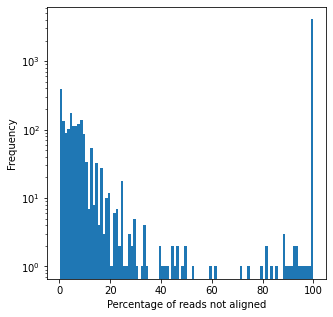

In [26]:
contig_unmaprate['Un_map_rate'].plot.hist(bins = 100, logy=True, figsize=(5,5))
plt.ylabel('Frequency')#, fontsize=16)
plt.xlabel('Percentage of reads not aligned')#, fontsize=16)
plt.show()

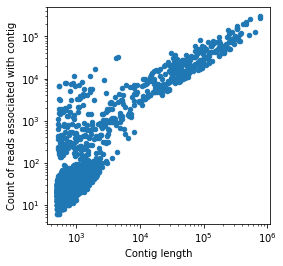

In [27]:
contig_unmaprate.plot.scatter(x = 'contig_len',
                              y = 'read_cnt',
                              figsize = (4,4)
                             )
plt.ylabel('Count of reads associated with contig')#, fontsize=16)
plt.xlabel('Contig length')#, fontsize=16)
plt.xscale('log')
plt.yscale('log')

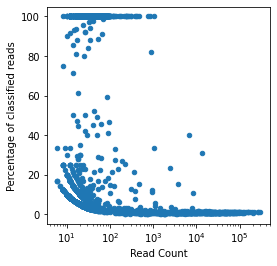

In [28]:
contig_unmaprate.plot.scatter(x = 'read_cnt', 
                      y = 'Un_map_rate',
                      figsize = (4,4)
                      )
plt.ylabel('Percentage of classified reads')#, fontsize=16)
plt.xlabel('Read Count')#, fontsize=16)
plt.xscale('log')
#plt.yscale('log')

In [29]:
max_un_map_rate = 50 # maxmum percentage of the reads in a barcode that is not mapped to the k-mer database. 
contig_unmaprate_filtered = contig_unmaprate[contig_unmaprate['Un_map_rate']<=max_un_map_rate] # filter data
contig_unmaprate_filtered.head()

,bar,Un_map_rate,read_cnt,contig_len
0,NODE_1_length_768793_cov_24.658792,1.07,267847,768793
1,NODE_2_length_753727_cov_28.265874,1.13,299016,753727
2,NODE_3_length_640439_cov_13.759645,1.22,129188,640439
3,NODE_4_length_543049_cov_34.676574,1.01,264627,543049
4,NODE_5_length_515789_cov_14.030391,1.31,106377,515789


In [31]:
valid_contigs = contig_unmaprate_filtered['bar'].to_list()
print(len(valid_contigs))

1714


In [124]:
contig_abds_filtered = contig_abds[contig_abds.index.isin(valid_contigs)]
contig_abds_filtered.loc[:, (contig_abds_filtered != 0).any(axis=0)]

contig_abds_filtered.to_csv(out_dir+'zymo_meta_contig_genus_abundance_filtered.csv')

contig_abds_filtered.head()

,Bacillus,Priestia,Metabacillus,Anoxybacillus,Cytobacillus,Staphylococcus,Listeria,Limosilactobacillus,Enterococcus,Salmonella,...,Brettanomyces,Ogataea,Sporolactobacillus,Actinomyces,Proteus,Naumovozyma,Methylophaga,Saliniradius,Komagataella,Variovorax
bar,,,,,,,,,,,,,,,,,,,,,
NODE_1_length_768793_cov_24.658792,0.99819,0.0001,0.00006,0.00005,0.00004,0.00031,0.00008,0.00011,0.00009,0.00012,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
NODE_2_length_753727_cov_28.265874,0.00026,0.0000,0.00000,0.00000,0.00008,0.00037,0.00031,0.00011,0.99613,0.00014,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
NODE_3_length_640439_cov_13.759645,0.00000,0.0000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00011,0.00000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
NODE_4_length_543049_cov_34.676574,0.00014,0.0000,0.00000,0.00000,0.00000,0.00012,0.99725,0.00011,0.00011,0.00011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
NODE_5_length_515789_cov_14.030391,0.00000,0.0000,0.00000,0.00000,0.00000,0.00000,0.00010,0.00016,0.00011,0.00012,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Combine EASi-seq data with Metagenomic contigs

1. single cell anndata:

/drive4/xiangpeng/Project/bacteria/Zymo_novoseq4/split/scFASTQ/analysis/Zymo_kraken_anndata.h5ad

2. contig data frame: 

/drive1/xiangpeng/Project/bacteria/zymo_std/D6300_ZRC195925/splitted/analysis/zymo_contigs_genus_kraken_abandance_filtered.csv

In [197]:
sc.settings.verbosity = 1             # verbosity: errors (0), warnings (1), info (2), hints (3)
#sc.logging.print_versions()
sc.settings.set_figure_params(dpi=300, figsize=(5, 5), facecolor='white')

In [178]:
# load the EASi-seq zymo data
adata_sc=anndata.read_h5ad('/drive4/xiangpeng/Project/bacteria/Zymo_novoseq4/split/scFASTQ/analysis/Zymo_genus_adata_processed.h5ad')
adata_sc

AnnData object with n_obs × n_vars = 1805 × 480
    obs: 'leiden', 'celltype', 'species_input', 'genus_input', 'matches'
    uns: 'celltype_colors', "dendrogram_['celltype']", 'dendrogram_celltype', 'leiden', 'leiden_colors', 'matches_colors', 'neighbors', 'rank_genes_groups', 'species_input_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    obsp: 'connectivities', 'distances'

In [179]:
# load the contig data
adata_contig=anndata.AnnData(contig_abds, dtype = np.float32)

In [180]:
adata_contig#.write(('/drive4/xiangpeng/Project/bacteria/Zymo_novoseq4/split/scFASTQ/analysis/Zymo_metagenomic_contig_genus_adata_processed.h5ad'))

AnnData object with n_obs × n_vars = 4844 × 223

In [181]:
# because the EASi-seq data and the metagenomic data might have different variables. 
# need to match them by adding the difference (the two data need to include all variables) 
contig_add = adata_sc.var_names.difference(adata_contig.var_names)
sc_add = adata_contig.var_names.difference(adata_sc.var_names)
print(len(sc_add),len(contig_add))

50 307


In [182]:
# make a all 0 anndata with the different variables and append it to the original contig data
contig_add_ad =  anndata.AnnData(
    X=np.zeros((adata_contig.shape[0],len(contig_add)), dtype=np.float32),
    obs = adata_contig.obs,
    var = pd.DataFrame(index =contig_add)
) 
print(adata_contig.shape)
adata_contig =anndata.concat([adata_contig,contig_add_ad], axis =1)

print(adata_contig.shape)

(4844, 223)
(4844, 530)


In [183]:
#find common variables in both datasets
shared_cols =adata_sc.var_names.intersection(adata_contig.var_names)
adata_sc = adata_sc[:,shared_cols]
adata_contig = adata_contig[:, shared_cols]
adata_contig 

View of AnnData object with n_obs × n_vars = 4844 × 480

In [184]:
DEFINED_NEIGHB_NUM =15
sc.pp.pca(adata_sc)
sc.pp.neighbors(adata_sc, n_neighbors = DEFINED_NEIGHB_NUM )
sc.tl.umap(adata_sc)


In [185]:
b = np.array(list(map(len, adata_sc.obsp['distances'].tolil().rows))) # number of neighbors of each cell
adata_sc_subset = adata_sc[np.where(b == DEFINED_NEIGHB_NUM-1)[0]] # select only those with the right number
sc.pp.neighbors(adata_sc_subset, DEFINED_NEIGHB_NUM) # rebuild the neighbor graph
adata_sc = adata_sc[b]

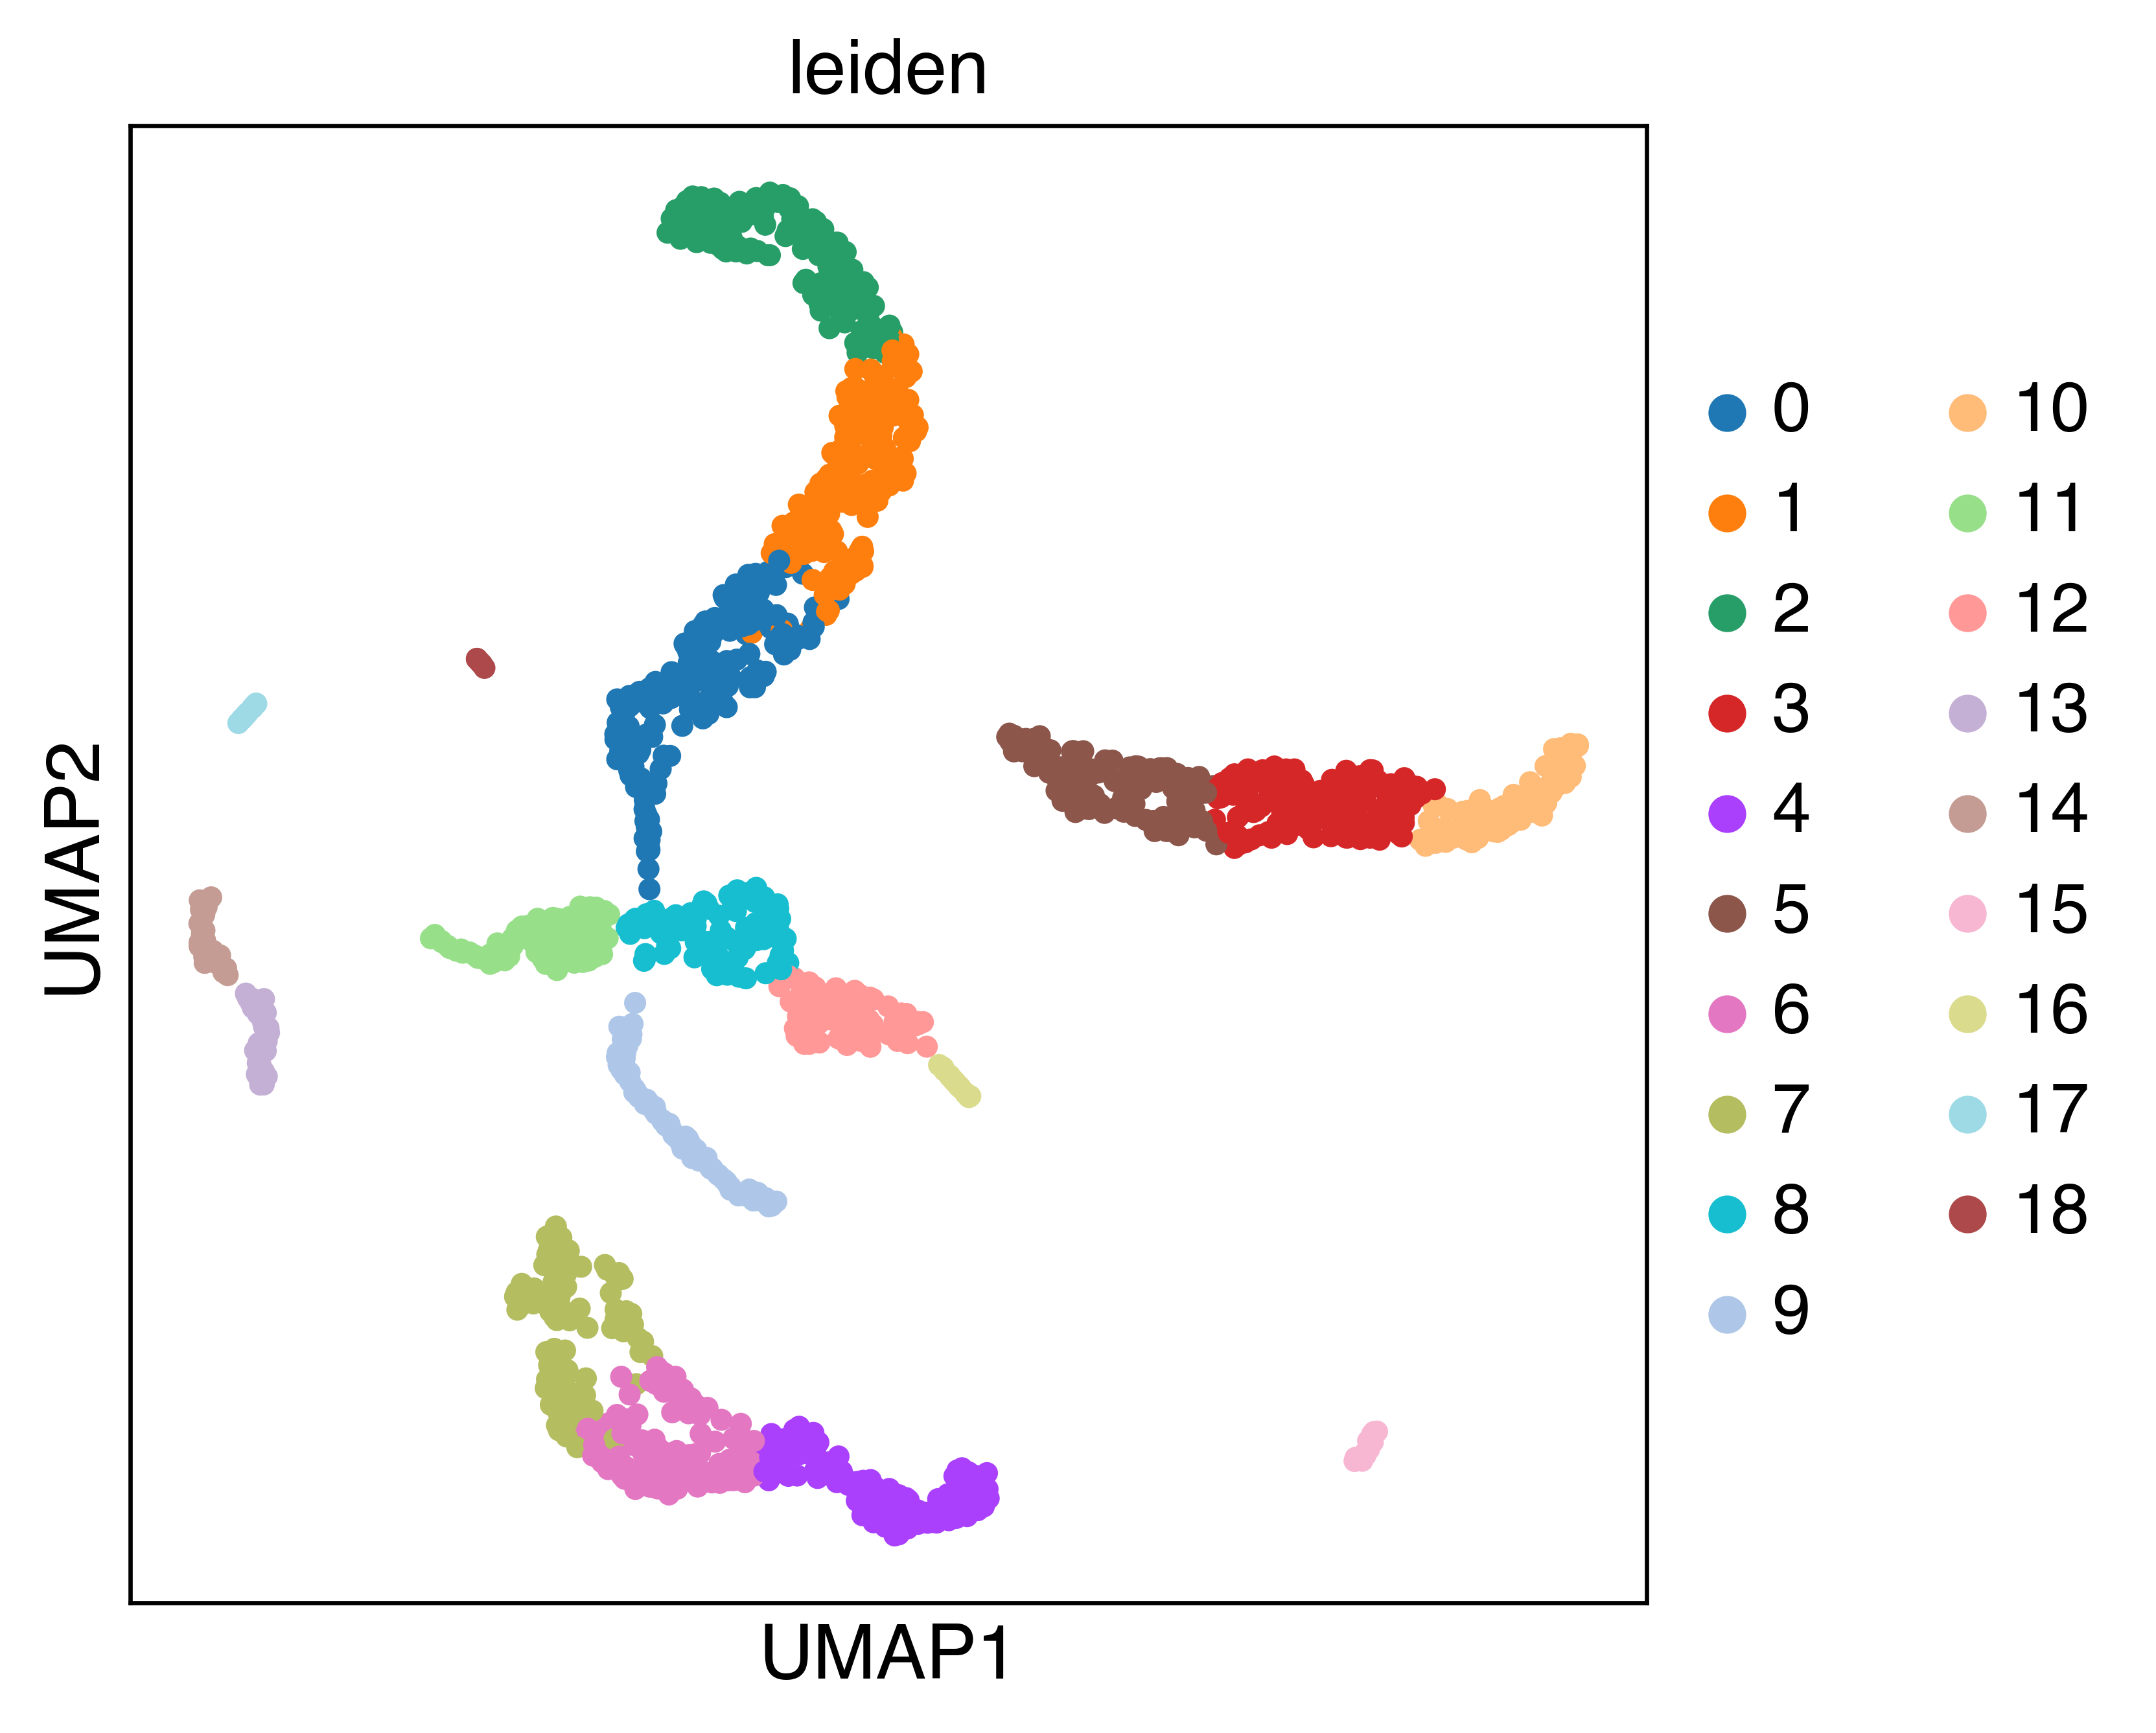

In [198]:
sc.pl.umap(adata_sc_subset, color='leiden')

### Map contigs using Ingest

In [187]:
sc.tl.ingest(adata_contig, adata_sc_subset, obs='leiden',embedding_method='umap')
adata_contig.uns['leiden_colors'] = adata_sc_subset.uns['leiden_colors']

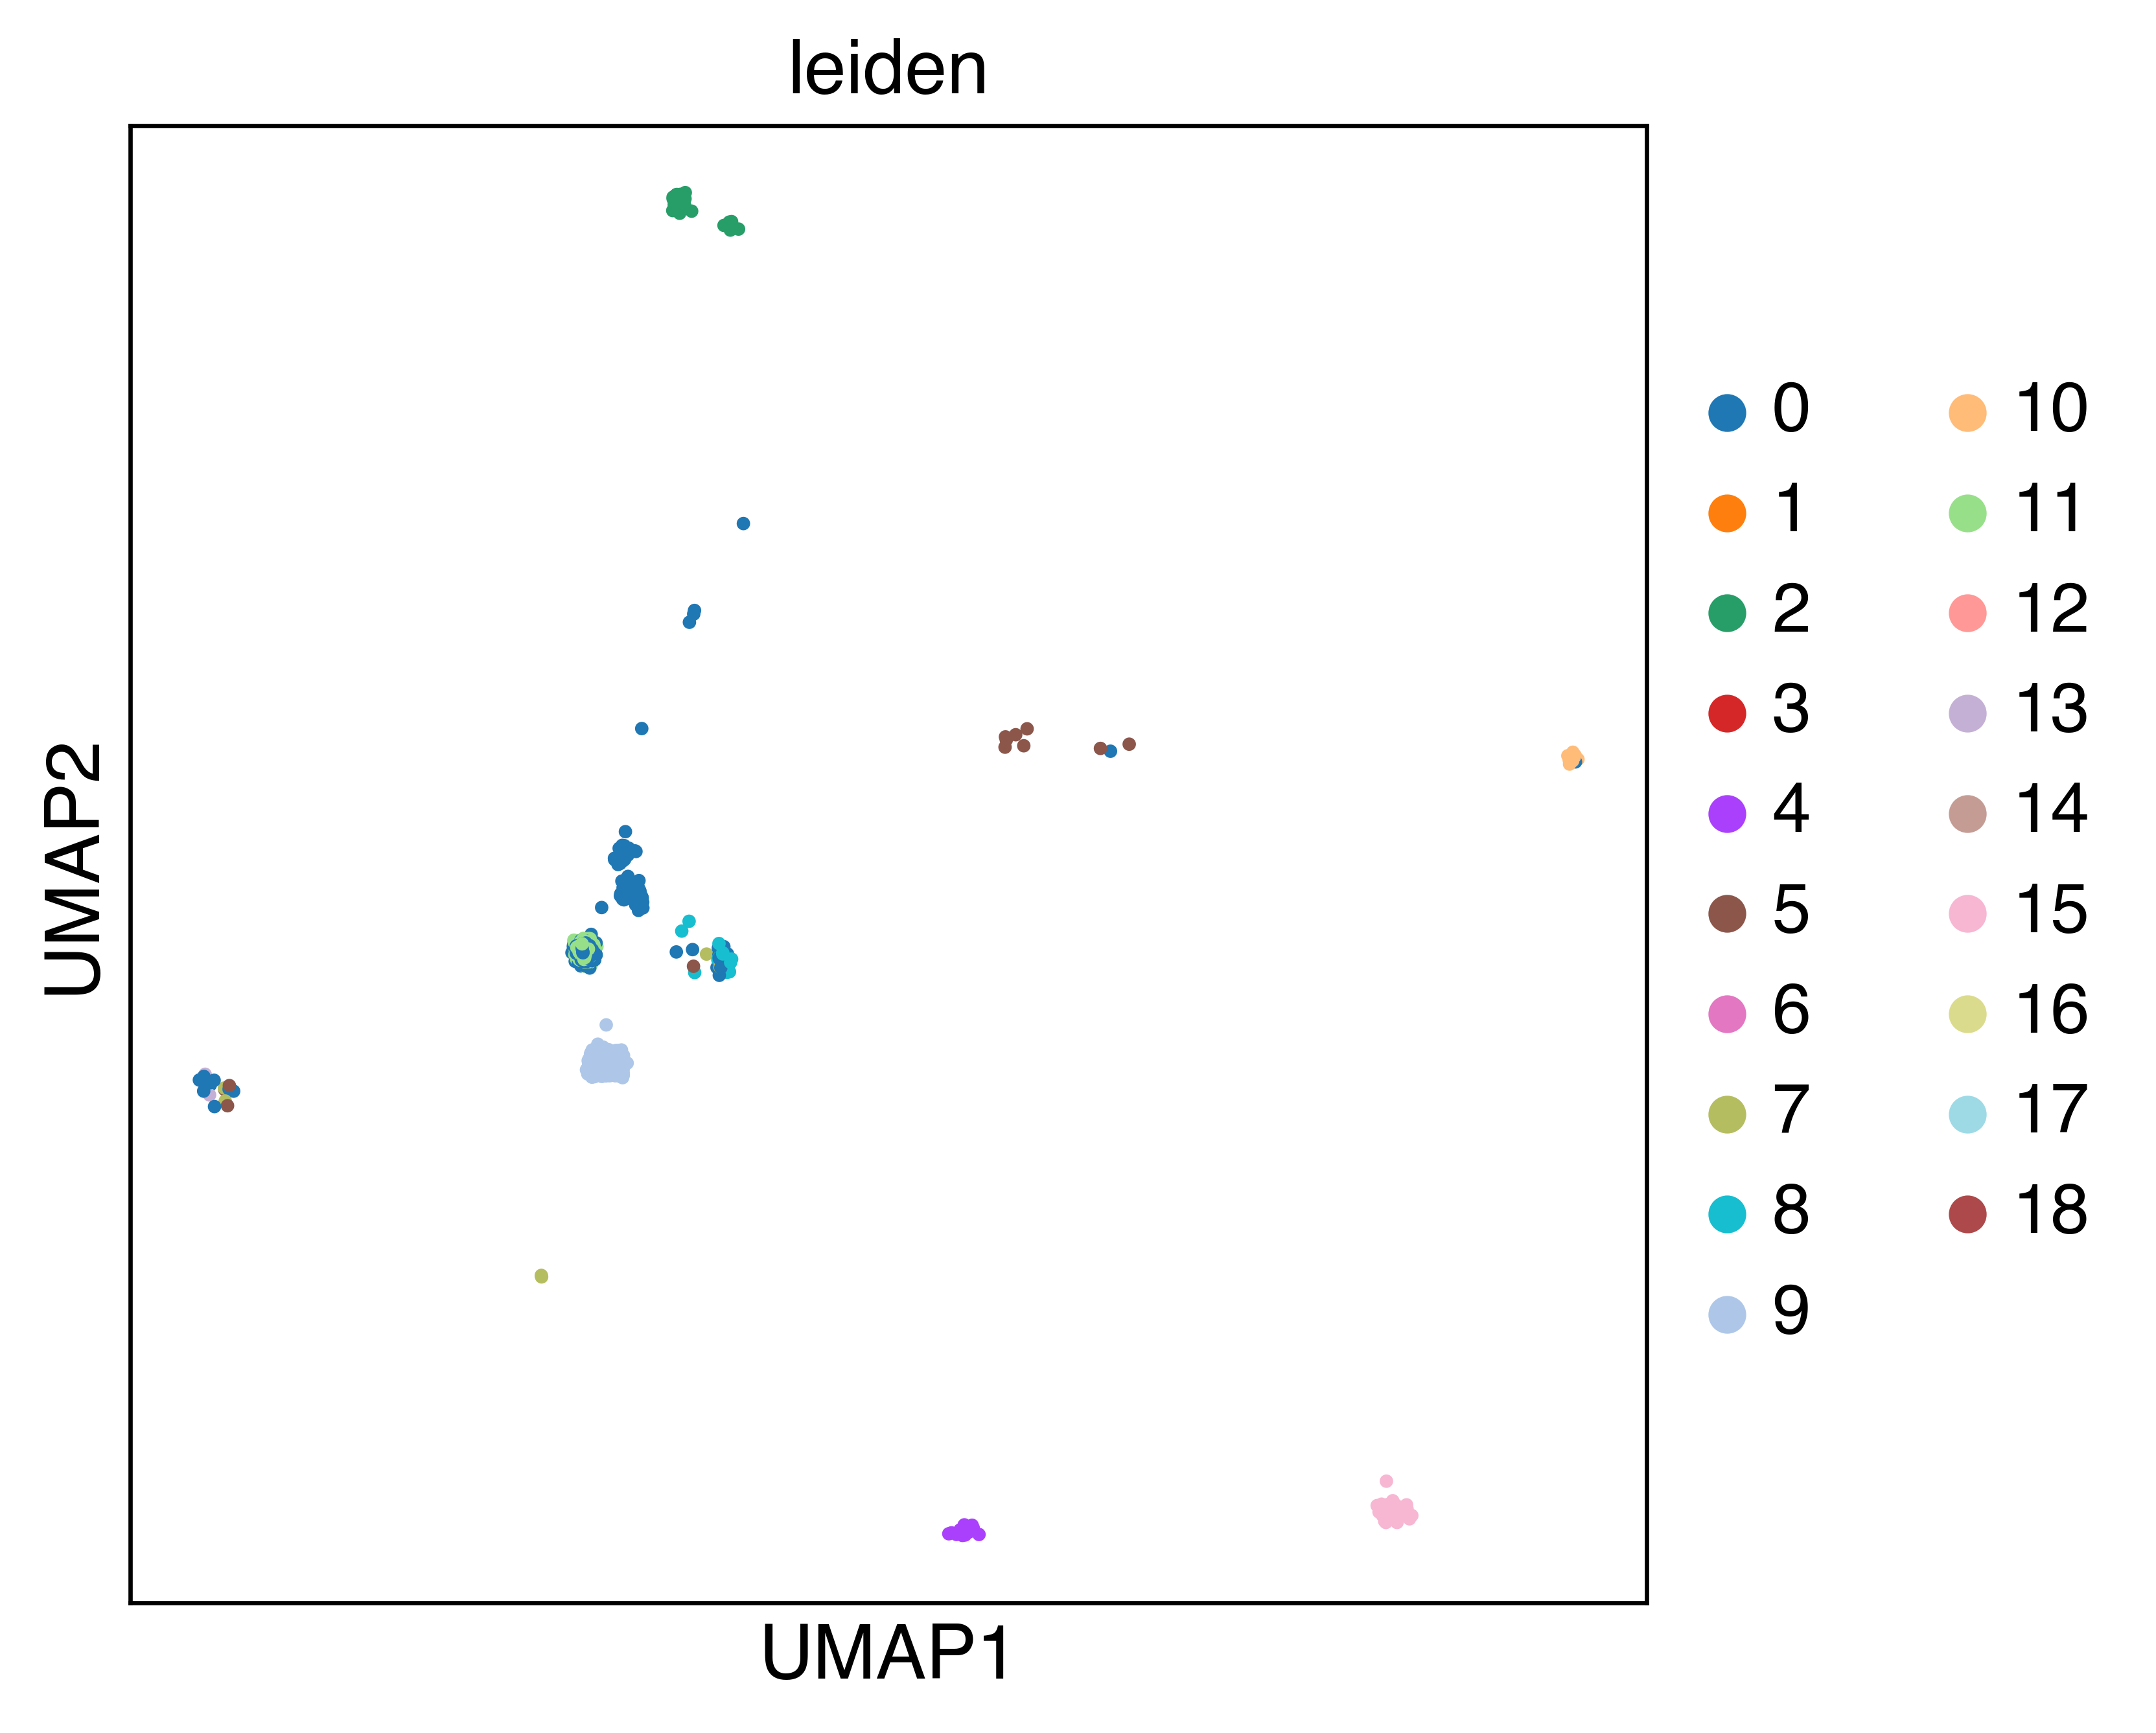

In [199]:
sc.pl.umap(adata_contig, color=['leiden'], wspace=0.5)

In [189]:
adata_concat = adata_sc_subset.concatenate(adata_contig, batch_categories=['single_cell', 'contig'])

/usr/local/lib/python3.9/dist-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


In [190]:
adata_concat.obs.leiden = adata_concat.obs.leiden.astype('category')
adata_concat.obs.leiden.cat.reorder_categories(adata_sc_subset.obs.leiden.cat.categories, inplace = True)
adata_concat.uns['leiden_colors']=adata_sc_subset.uns['leiden_colors']

/tmp/ipykernel_59983/177103649.py:2: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  adata_concat.obs.leiden.cat.reorder_categories(adata_sc_subset.obs.leiden.cat.categories, inplace = True)


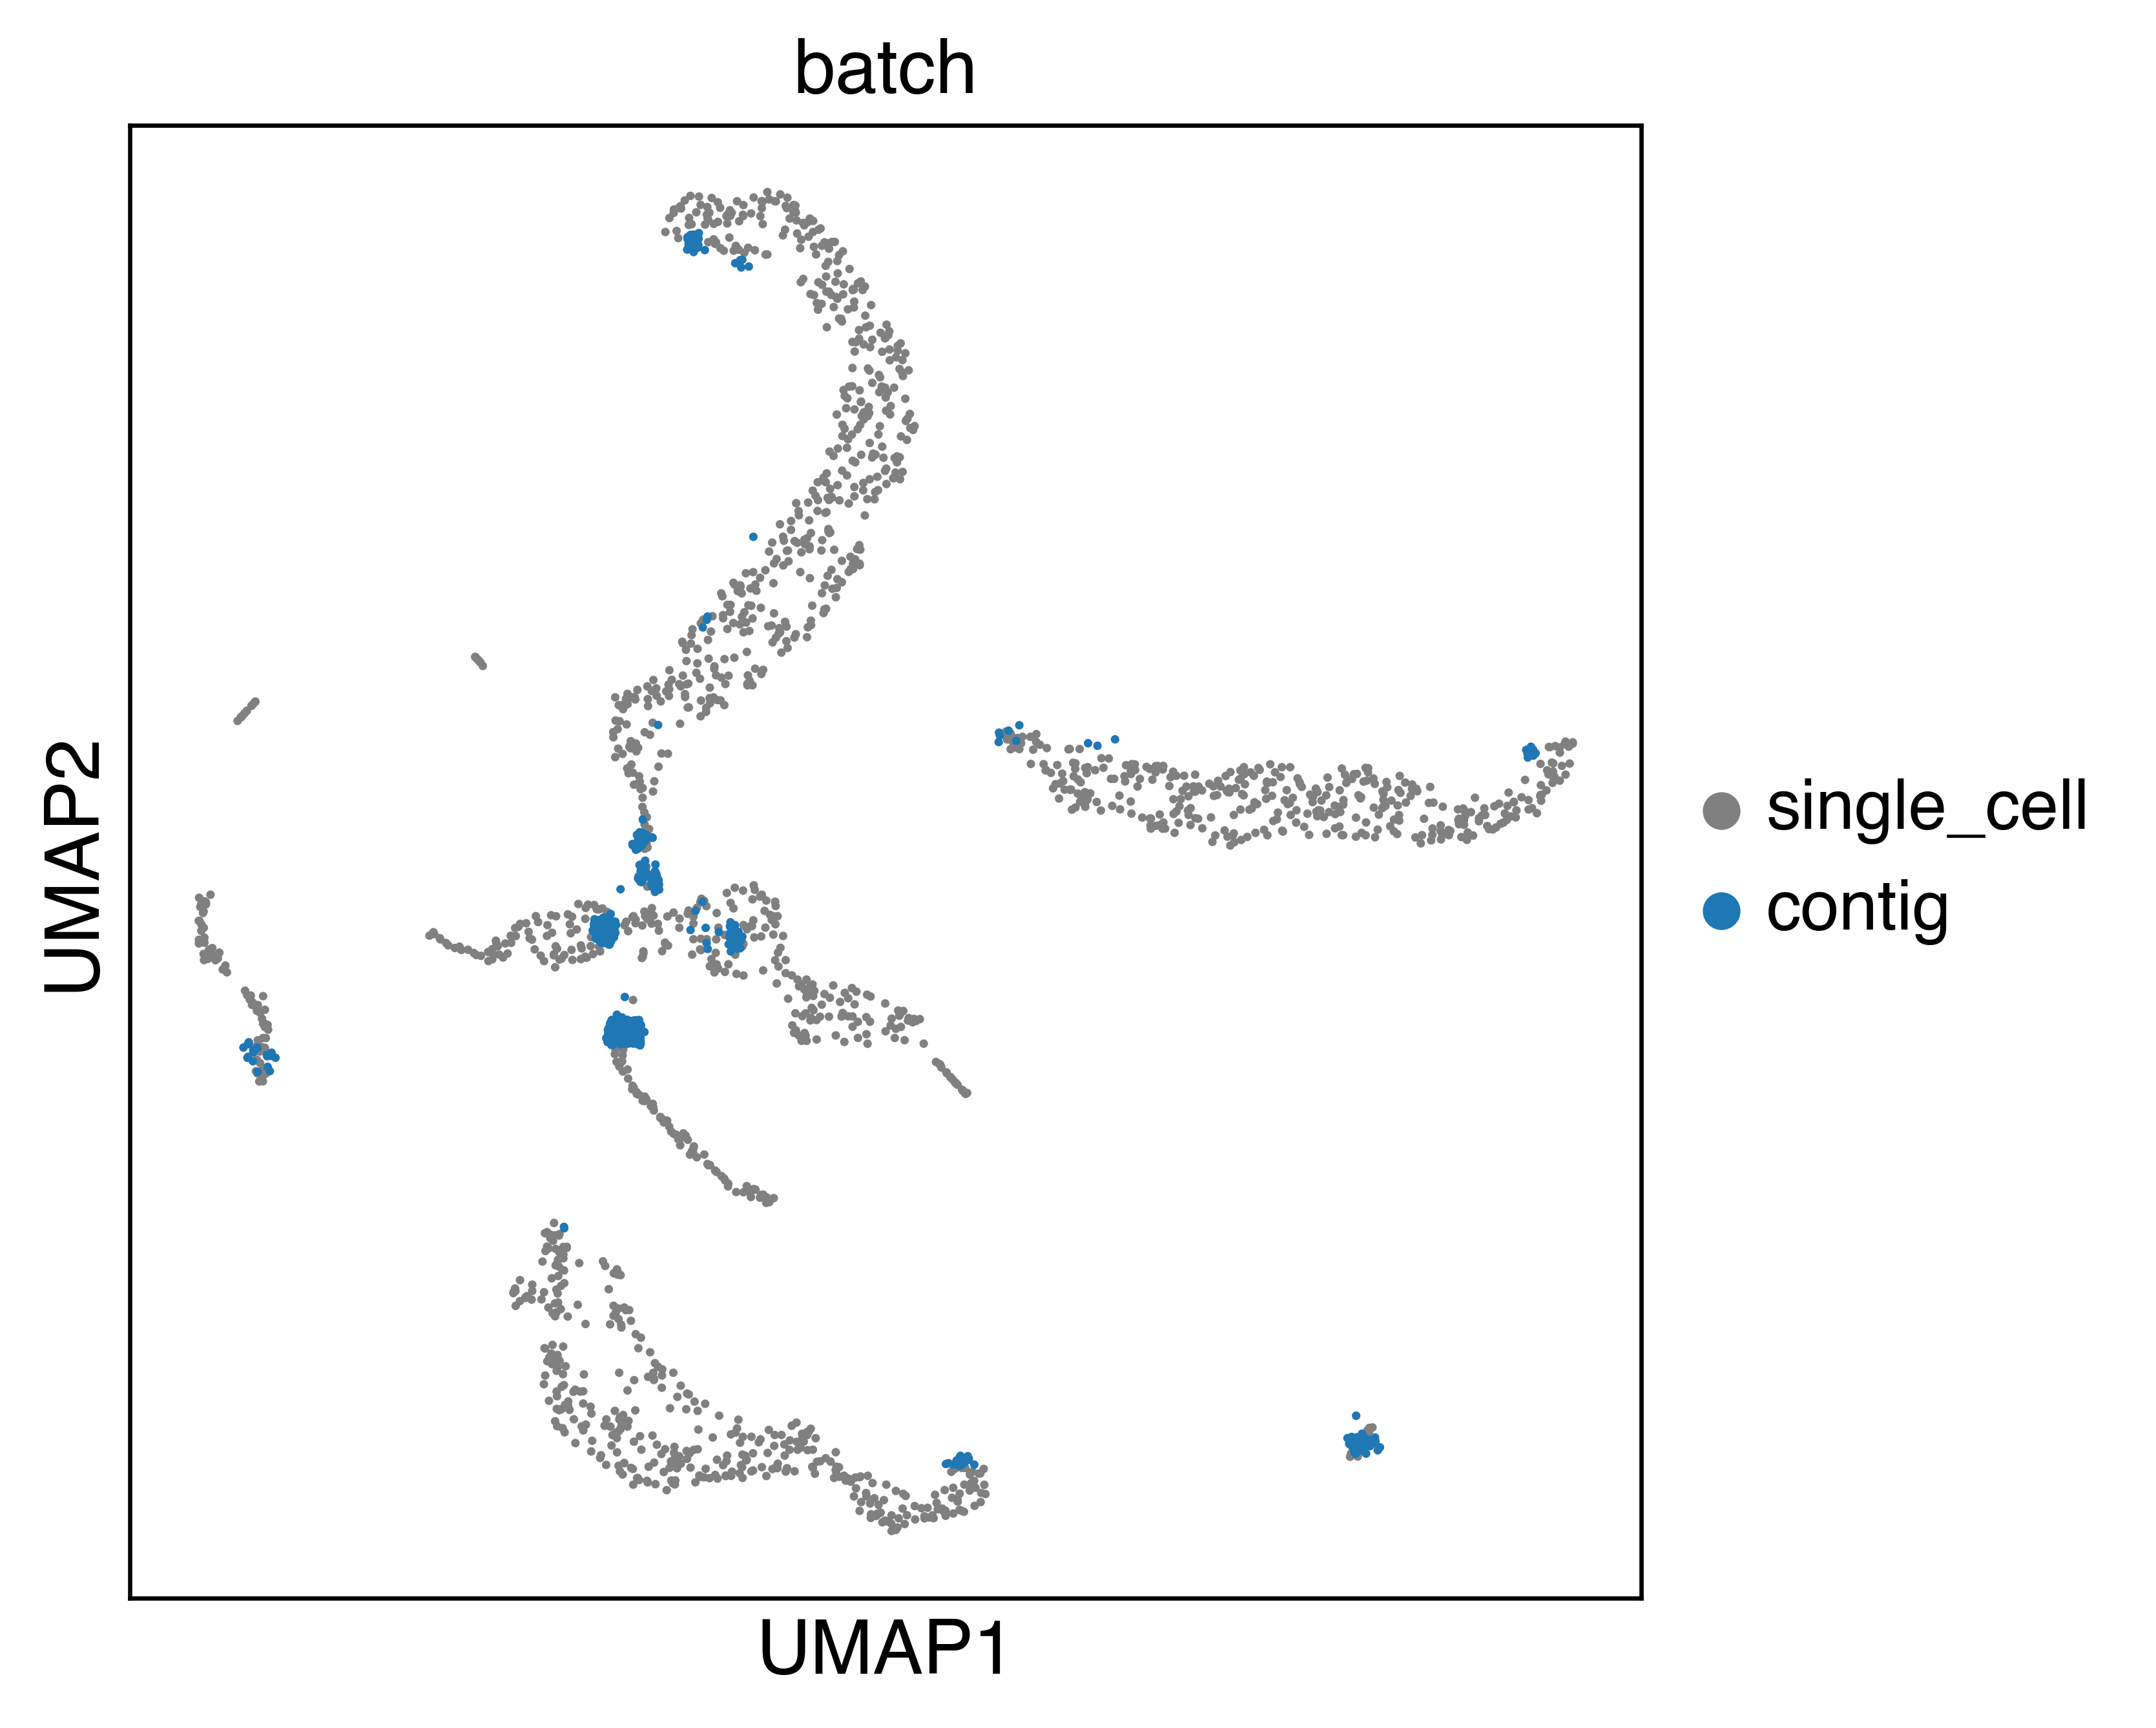

In [200]:
batch_colors = ['grey', 'tab:blue']
sc.pl.umap(adata_concat, color=['batch'], size = 10, palette=batch_colors)

In [192]:
contig_df =  adata_contig.to_df()
contig_df['Genus']= contig_df.idxmax(axis=1)
genus_cnt =  contig_df['Genus'].value_counts().to_dict()
contig_genus = contig_df['Genus'].to_dict() 

bar_genus = adata_sc_subset.obs['genus_input'].to_dict()

dict_contig_genus ={}
main_genus=[]

for c in contig_genus:
    genus = contig_genus[c]
    g_cnt = genus_cnt[genus]
    dict_contig_genus[c + '-contig']= 'other'
    if g_cnt >= 10:
        dict_contig_genus[c + '-contig']=genus
        if genus not in main_genus:
            main_genus.append(genus)
    
for bar in bar_genus:
    dict_contig_genus[bar + '-single_cell']=bar_genus[bar]

In [193]:
adata_concat.obs['genus_input']=  adata_concat.obs.index.map(dict_contig_genus).astype('category')

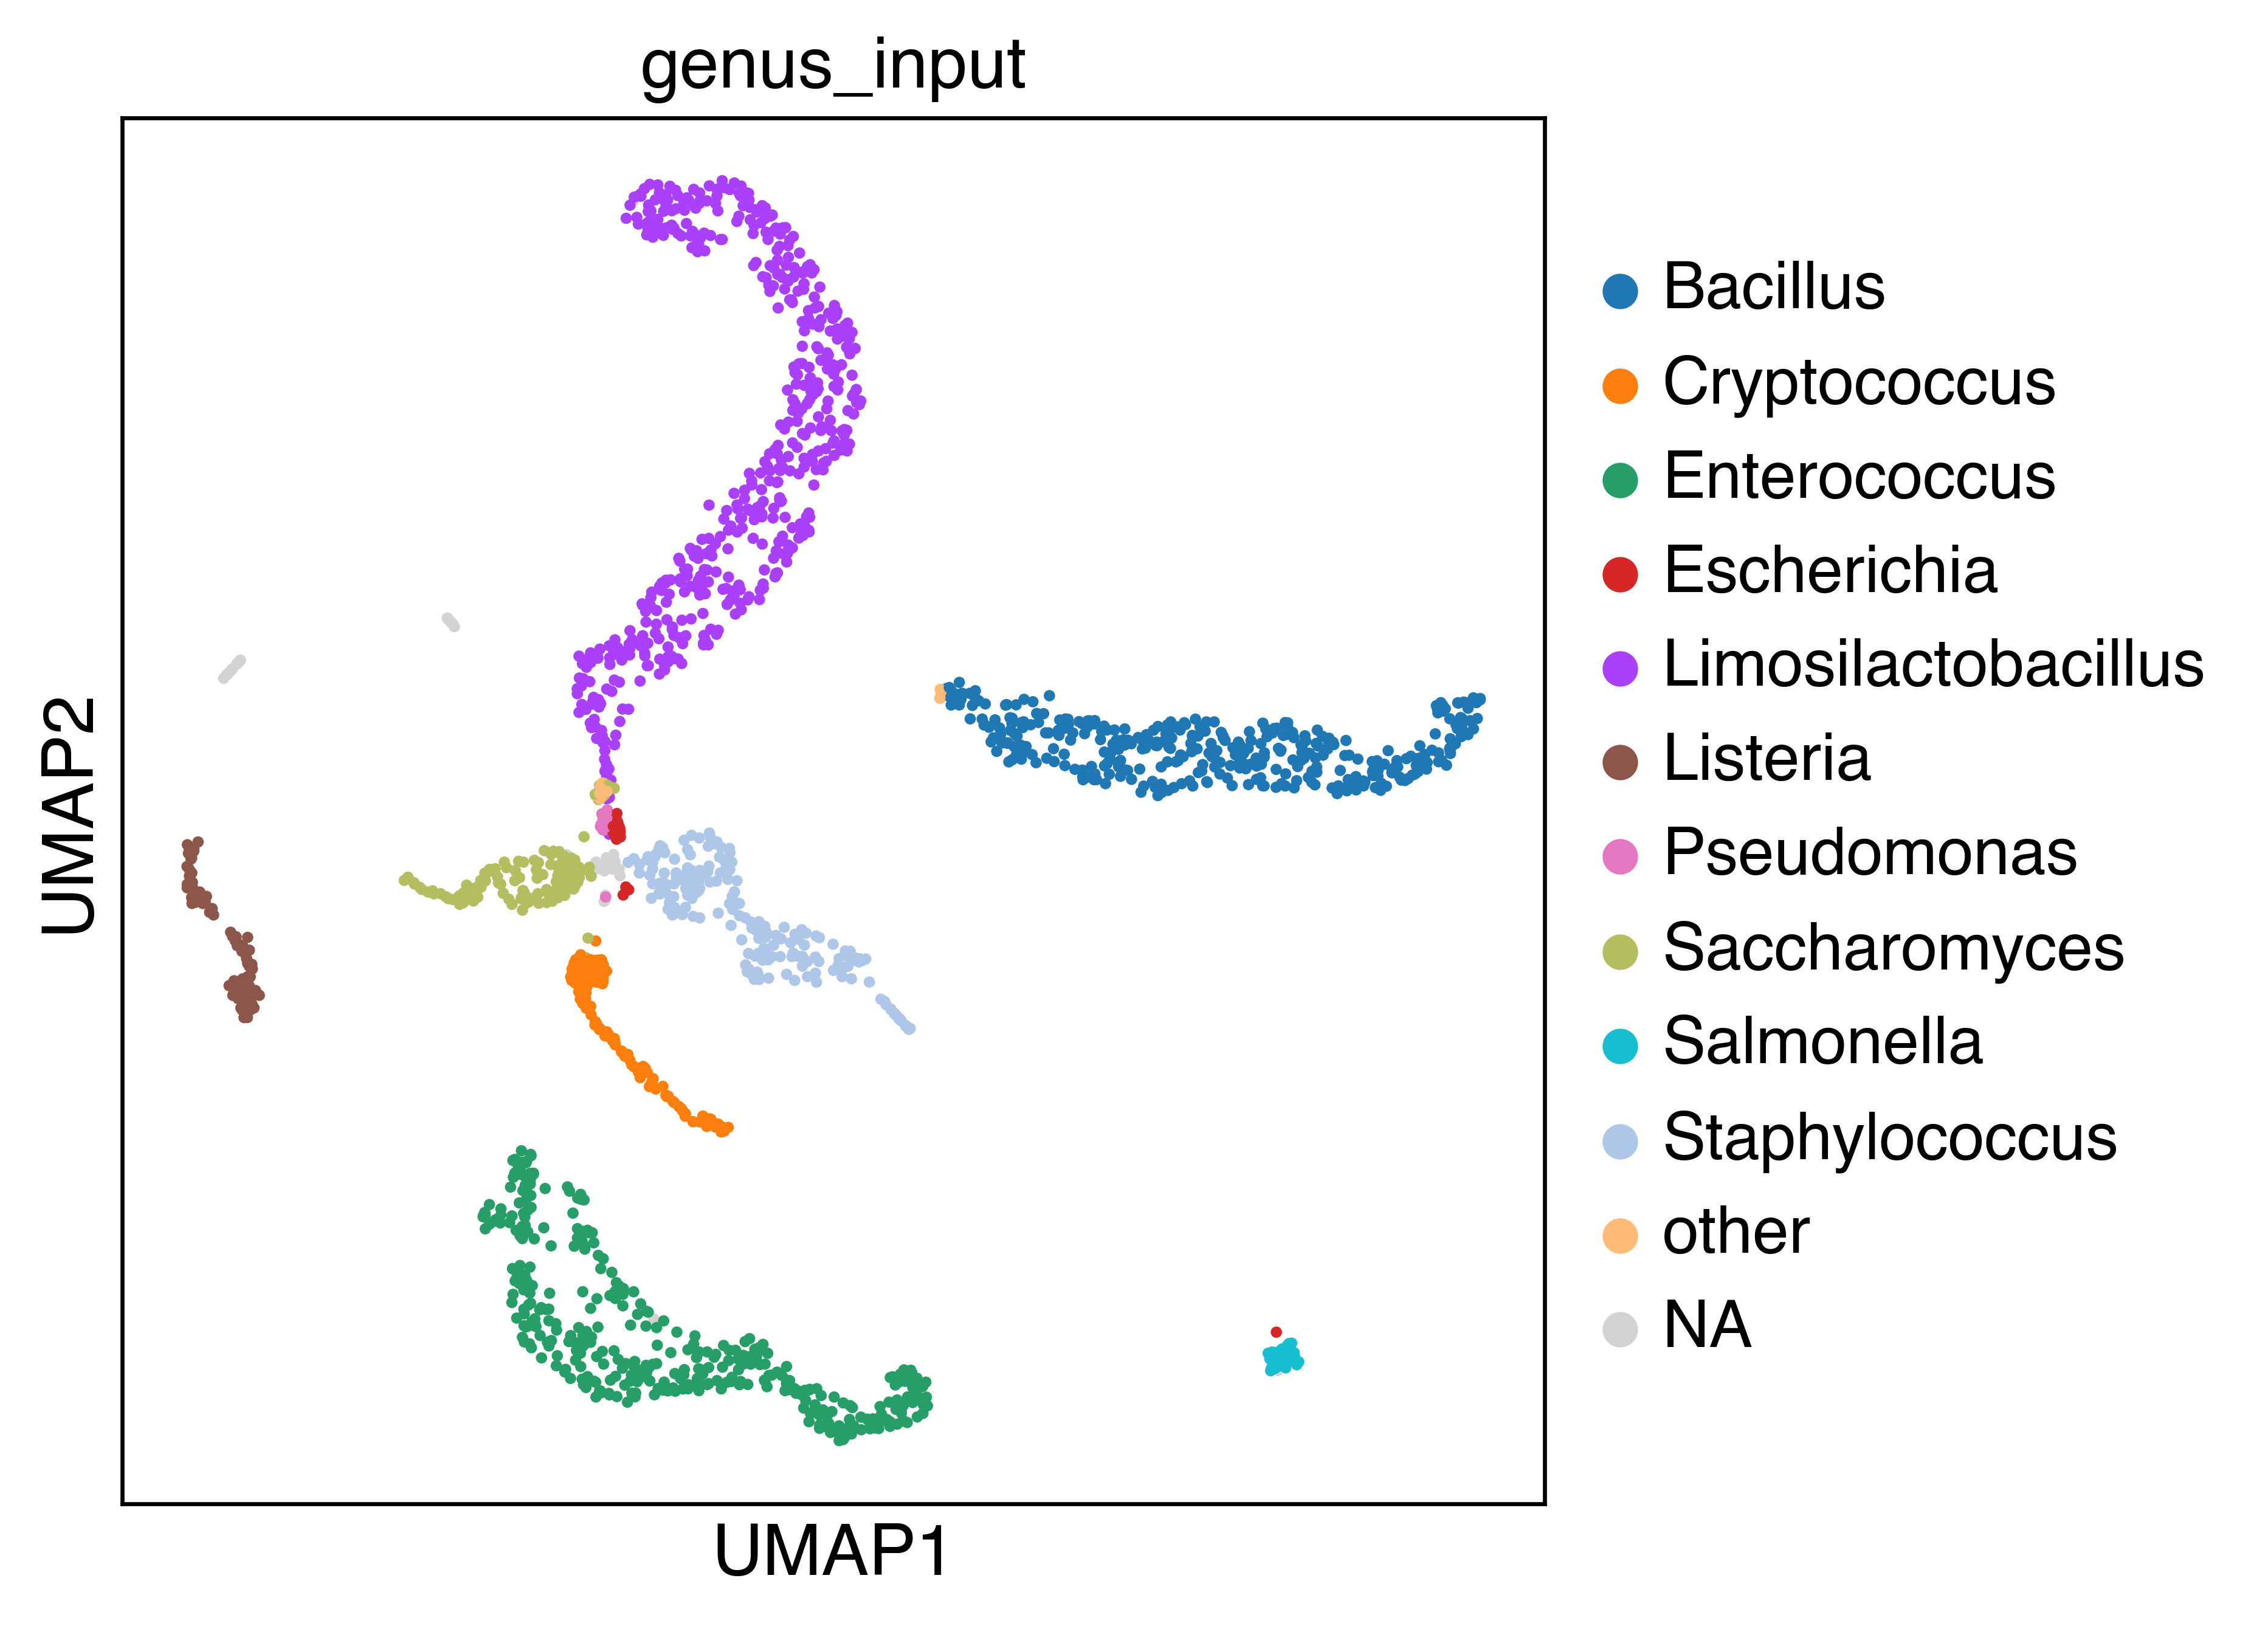

In [201]:
sc.pl.umap(adata_concat, color=['genus_input'], size = 20)

In [195]:
adata_concat.write(out_dir + 'Zymo_easi_and_metagenomics_anndata.h5ad')

## Cluster Assembly
In this section, we will combine all the reads that assigned to the same clusters, assemble, and evaluate the resulting contigs. 


In [207]:
cluster_df = adata_concat.obs
cluster_df = pd.concat([cluster_df, pd.DataFrame(adata_concat.obsm['X_umap'], index=cluster_df.index)],axis =1)
cluster_df = cluster_df.rename(columns={0:'UMAP_1', 1:'UMAP_2'})
cluster_df['UMAP_1'] = cluster_df['UMAP_1'].apply(pd.to_numeric)
cluster_df['UMAP_2'] = cluster_df['UMAP_2'].apply(pd.to_numeric)

In [211]:
genus_bar_cnt = cluster_df['genus_input'].value_counts().to_dict() # barcode counts of each barcodes
print(genus_bar_cnt)# the minimal valid cluster count is 93

{'Saccharomyces': 3313, 'Cryptococcus': 1185, 'Limosilactobacillus': 627, 'Enterococcus': 420, 'Bacillus': 409, 'Staphylococcus': 213, 'Escherichia': 121, 'Pseudomonas': 105, 'Listeria': 95, 'Salmonella': 93, 'other': 14}


In [216]:
cluster_ID_ls = [] # list all the clusters
for cluster in genus_bar_cnt:
    if genus_bar_cnt[cluster] >= 93:
        cluster_ID_ls.append(cluster)
        
        
print(cluster_ID_ls)  

['Saccharomyces', 'Cryptococcus', 'Limosilactobacillus', 'Enterococcus', 'Bacillus', 'Staphylococcus', 'Escherichia', 'Pseudomonas', 'Listeria', 'Salmonella']


In [220]:
cluster_df.head()

,leiden,celltype,species_input,genus_input,matches,batch,UMAP_1,UMAP_2
bar,,,,,,,,
AACAACTGGTAGTGATCC-2-single_cell,6,Enterococcus,Enterococcus_faecalis,Enterococcus,match,single_cell,5.872589,-10.271855
AACAATGCACTTCCGTGG-2-single_cell,12,Staphylococcus,Staphylococcus_aureus,Staphylococcus,match,single_cell,7.531514,0.070854
AACAATGCAGACTTCACC-1-single_cell,11,Saccharomyces,Saccharomyces_cerevisiae,Saccharomyces,match,single_cell,2.161134,2.272929
AACACACTCCCTGCAGAT-2-single_cell,5,Bacillus,Bacillus_subtilis,Bacillus,match,single_cell,16.956741,5.767852
AACACACTCTTGGTAACT-1-single_cell,4,Enterococcus,Enterococcus_faecalis,Enterococcus,match,single_cell,8.631296,-10.058744


In [222]:
cluster_stat = pd.DataFrame(index=cluster_ID_ls, columns=['sc_bar_cnt', 'contig_bar_cnt']) # make a new pd dataframe to save the cluster evaluation stats. 
for c in cluster_ID_ls: 
    sc_cnt = len(cluster_df[(cluster_df['genus_input']==c)&(cluster_df['batch']=='single_cell')].index)
    contig_cnt = len(cluster_df[(cluster_df['genus_input']==c)&(cluster_df['batch']=='contig')].index)
    cluster_stat.loc[c, 'sc_bar_cnt':'contig_bar_cnt']=[sc_cnt,contig_cnt]


<AxesSubplot:>

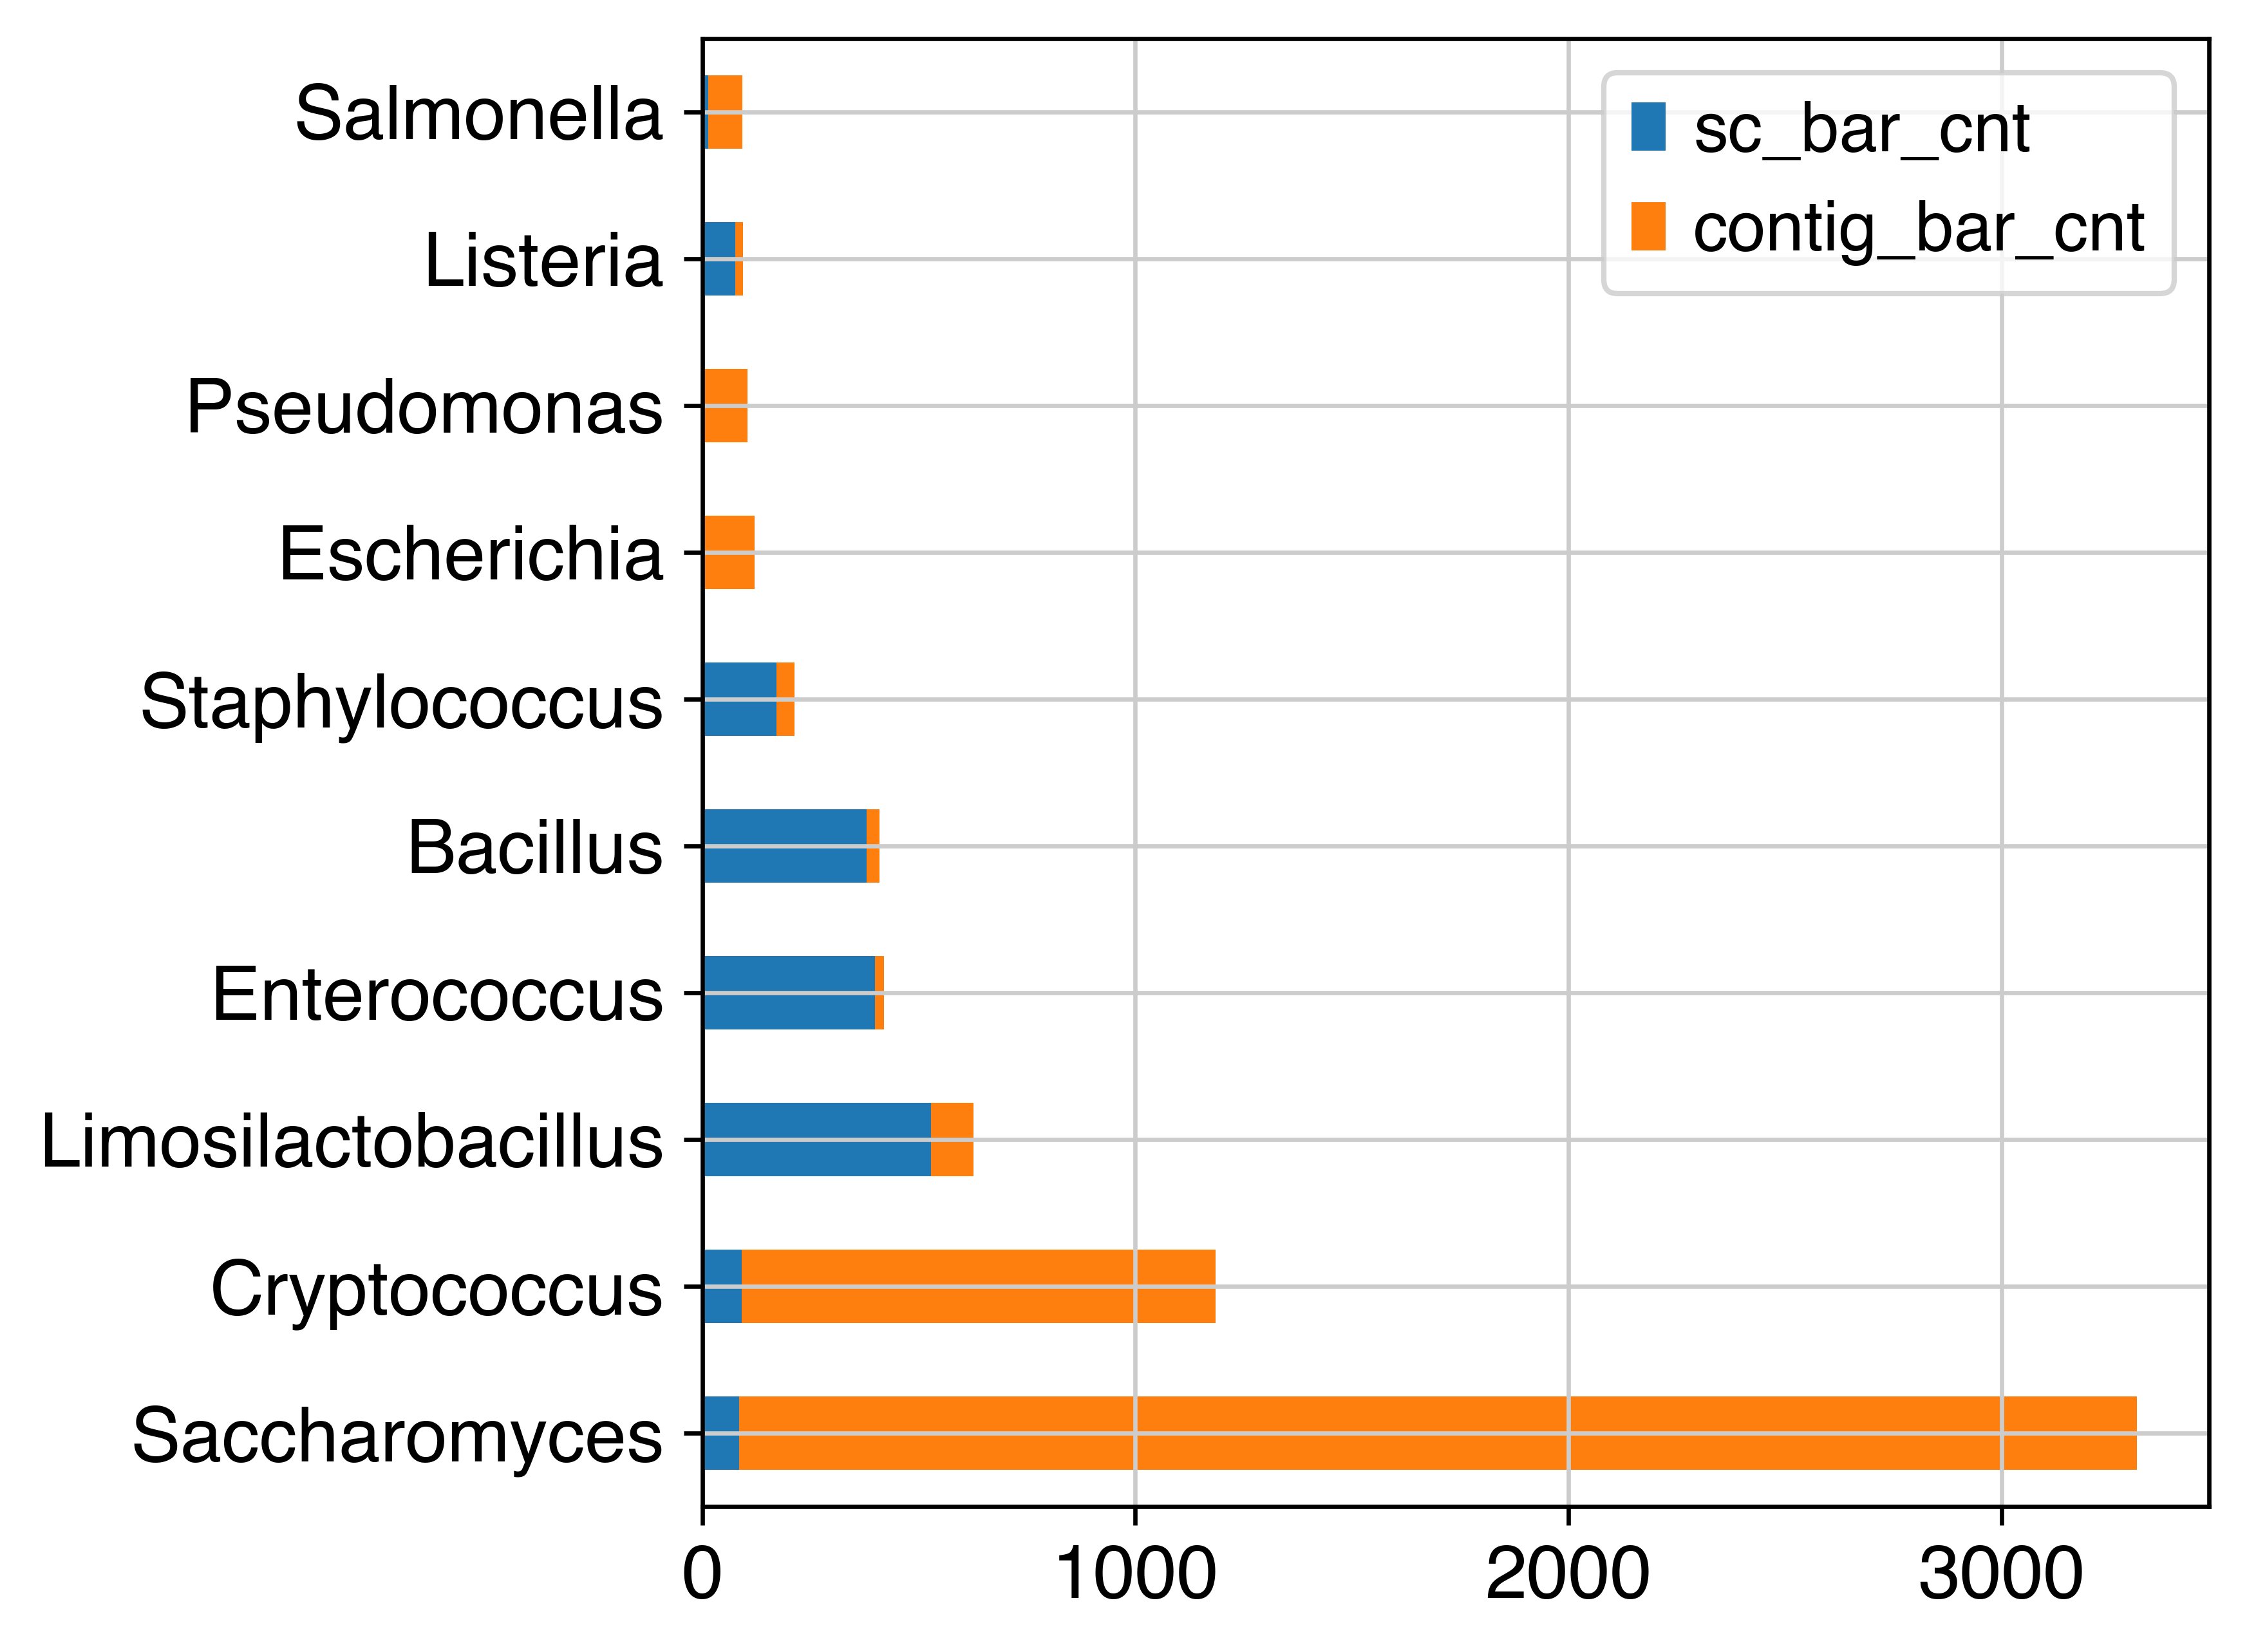

In [223]:
cluster_stat.plot.barh(stacked=True)

### Group cluster reads to assembly

##### Group single cell reads by cluster IDs

In [226]:
##### group single cell reads by cluster IDs.

sc_out_dir = '/drive1/xiangpeng/Project/bacteria/zymo_std/D6300_ZRC195925/splitted/single_cell/'
fq_dir = '/drive4/xiangpeng/Project/bacteria/Zymo_novoseq4/split/scFASTQ/fq/'

cluster_sc_bar_counts = {}
for c in cluster_ID_ls:
    c_dir = sc_out_dir + c +'/'
    mkdir_cmd = 'mkdir {}'.format(c_dir)
    print(mkdir_cmd)
    os.system(mkdir_cmd)
        
    idx_ls = cluster_df[(cluster_df['genus_input']==c)&(cluster_df['batch']=='single_cell')].index.tolist()
    print('In {} cluster, there are totally {} barcodes'.format(c, len(idx_ls)))
    cluster_sc_bar_counts[c]=len(idx_ls)
    
    header_file = c_dir + '{}_sc_bar.txt'.format(c)
    f = open(header_file, 'w')
    for idx in idx_ls:
        bar = idx.split('-single')[0]
        f.write('{}\n'.format(bar))
    f.close()
    
    # move all the fq and comine them 
    print('copying fastq files for {}'.format(c))
    for idx in idx_ls:
        bar = idx.split('-single')[0]
        in_fq1 = fq_dir + bar + '_R1.fq'
        in_fq2 = fq_dir + bar + '_R2.fq'
        out_fq1 = c_dir + bar + '_R1.fq'
        out_fq2 = c_dir + bar + '_R2.fq'
        cp_cmd1 = 'cp {} {}'.format(in_fq1, out_fq1)
        cp_cmd2 = 'cp {} {}'.format(in_fq2, out_fq2)
        #os.system(cp_cmd1)
        #os.system(cp_cmd2)
    # combine all fq in a folder
    cat_cmd1 = 'cat {}*R1.fq > {}R1_combined.fastq'.format(c_dir, c_dir)
    cat_cmd2 = 'cat {}*R2.fq > {}R2_combined.fastq'.format(c_dir, c_dir)
   
    print(cat_cmd1, cat_cmd2)
    os.system(cat_cmd1)
    os.system(cat_cmd2)
    # remove barcode fq
    rm_cmd = 'rm {}*.fq'.format(c_dir)
    print(rm_cmd)
    os.system(rm_cmd)

mkdir /drive1/xiangpeng/Project/bacteria/zymo_std/D6300_ZRC195925/splitted/single_cell/Saccharomyces/
In Saccharomyces cluster, there are totally 86 barcodes
copying fastq files for Saccharomyces
cat /drive1/xiangpeng/Project/bacteria/zymo_std/D6300_ZRC195925/splitted/single_cell/Saccharomyces/*R1.fq > /drive1/xiangpeng/Project/bacteria/zymo_std/D6300_ZRC195925/splitted/single_cell/Saccharomyces/R1_combined.fastq cat /drive1/xiangpeng/Project/bacteria/zymo_std/D6300_ZRC195925/splitted/single_cell/Saccharomyces/*R2.fq > /drive1/xiangpeng/Project/bacteria/zymo_std/D6300_ZRC195925/splitted/single_cell/Saccharomyces/R2_combined.fastq
rm /drive1/xiangpeng/Project/bacteria/zymo_std/D6300_ZRC195925/splitted/single_cell/Saccharomyces/*.fq
mkdir /drive1/xiangpeng/Project/bacteria/zymo_std/D6300_ZRC195925/splitted/single_cell/Cryptococcus/
In Cryptococcus cluster, there are totally 91 barcodes
copying fastq files for Cryptococcus
cat /drive1/xiangpeng/Project/bacteria/zymo_std/D6300_ZRC195925/sp

#### Group metagenomic reads by cluster IDs
Extract pair end read from the metagenomic raw reads using seqtk (https://github.com/lh3/seqtk/blob/master/README.md)



In [234]:
# extract pair end fastq of all contigs by cluster IDs.
out_dir = '/drive1/xiangpeng/Project/bacteria/zymo_std/D6300_ZRC195925/splitted/contig_fq/'
fq_dir = '/drive1/xiangpeng/Project/bacteria/zymo_std/D6300_ZRC195925/'
header_file = fq_dir + 'contig_mapped_qname_rname_qscore.tsv' ## tsv file with qname, rname, and qscore, extracted from the bam file
raw_fq1 = fq_dir + 'in2170_1_R1.fastq.gz'
raw_fq2 = fq_dir + 'in2170_1_R2.fastq.gz'

qrnames = pd.read_csv(header_file,sep ='\t', names = ['read','contig', 'qscore'])
qrnames = qrnames[qrnames['contig']!='*'] # remove unmapped reads
qrnames = qrnames[qrnames['qscore']>=35] # only choose the high quality reads

for c in cluster_ID_ls:
    idx_ls = cluster_df[(cluster_df['genus_input']==c)&(cluster_df['batch']=='contig')].index.tolist()
    idx_ls_contig = []
    for idx in idx_ls:
        new_idx = idx.split('-')[0]
        idx_ls_contig.append(new_idx)
    
    df = qrnames[qrnames['contig'].isin(idx_ls_contig)]
    read_ls =  df['read'].unique().tolist()
    
    # save the read id as a txt 
    read_file = out_dir + c + '-contig-associated-reads.txt'
    file = open(read_file, 'w')
    for r in read_ls:
        file.write(r+'\n')
    file.close()
    print('Cluster {} associated read headers are savedin file {}'.format(c, read_file))
    
    
    
    # extract the reads from fastq files
    out_1 = out_dir + c + '_combined_R1.fq'
    out_2 = out_dir + c + '_combined_R2.fq'
    seqtk_cmd1 = 'seqtk subseq {} {} > {}'.format(raw_fq1, read_file, out_1)
    seqtk_cmd2 = 'seqtk subseq {} {} > {}'.format(raw_fq2, read_file, out_2)
    os.system(seqtk_cmd1)
    os.system(seqtk_cmd2)
    print('Cluster {} metagenomic reads are extracted and saved as {} and {}'.format(cluster, out_1, out_2))

Cluster Saccharomyces associated read headers are savedin file /drive1/xiangpeng/Project/bacteria/zymo_std/D6300_ZRC195925/splitted/contig_fq/Saccharomyces-contig-associated-reads.txt
Cluster other metagenomic reads are extracted and saved as /drive1/xiangpeng/Project/bacteria/zymo_std/D6300_ZRC195925/splitted/contig_fq/Saccharomyces_combined_R1.fq and /drive1/xiangpeng/Project/bacteria/zymo_std/D6300_ZRC195925/splitted/contig_fq/Saccharomyces_combined_R2.fq
Cluster Cryptococcus associated read headers are savedin file /drive1/xiangpeng/Project/bacteria/zymo_std/D6300_ZRC195925/splitted/contig_fq/Cryptococcus-contig-associated-reads.txt
Cluster other metagenomic reads are extracted and saved as /drive1/xiangpeng/Project/bacteria/zymo_std/D6300_ZRC195925/splitted/contig_fq/Cryptococcus_combined_R1.fq and /drive1/xiangpeng/Project/bacteria/zymo_std/D6300_ZRC195925/splitted/contig_fq/Cryptococcus_combined_R2.fq
Cluster Limosilactobacillus associated read headers are savedin file /drive1/x

#### Read counts

In [237]:
from subprocess import check_output

In [238]:
# collect all the single cell read count from the combined fastq files.
cluster_stat['sc_read_cnt']=0
for c in cluster_ID_ls:
    fq = '/drive1/xiangpeng/Project/bacteria/zymo_std/D6300_ZRC195925/splitted/single_cell/{}/R1_combined.fastq'.format(c)
    cmd ='grep "@A" {} |wc -l'.format(fq)
    out = check_output(cmd, shell=True)
    out = int(out)
    cluster_stat.loc[c,'sc_read_cnt']=out

In [239]:
# collect all the contig read counts
cluster_stat['contig_read_cnt']=0
for c in cluster_ID_ls:
    contig_fq = '/drive1/xiangpeng/Project/bacteria/zymo_std/D6300_ZRC195925/splitted/contig_fq/{}_combined_R1.fq'.format(c)
    cmd ='grep "@M" {} |wc -l'.format(contig_fq)
    out = check_output(cmd, shell=True)
    out = int(out)
    cluster_stat.loc[c,'contig_read_cnt']=out

<AxesSubplot:>

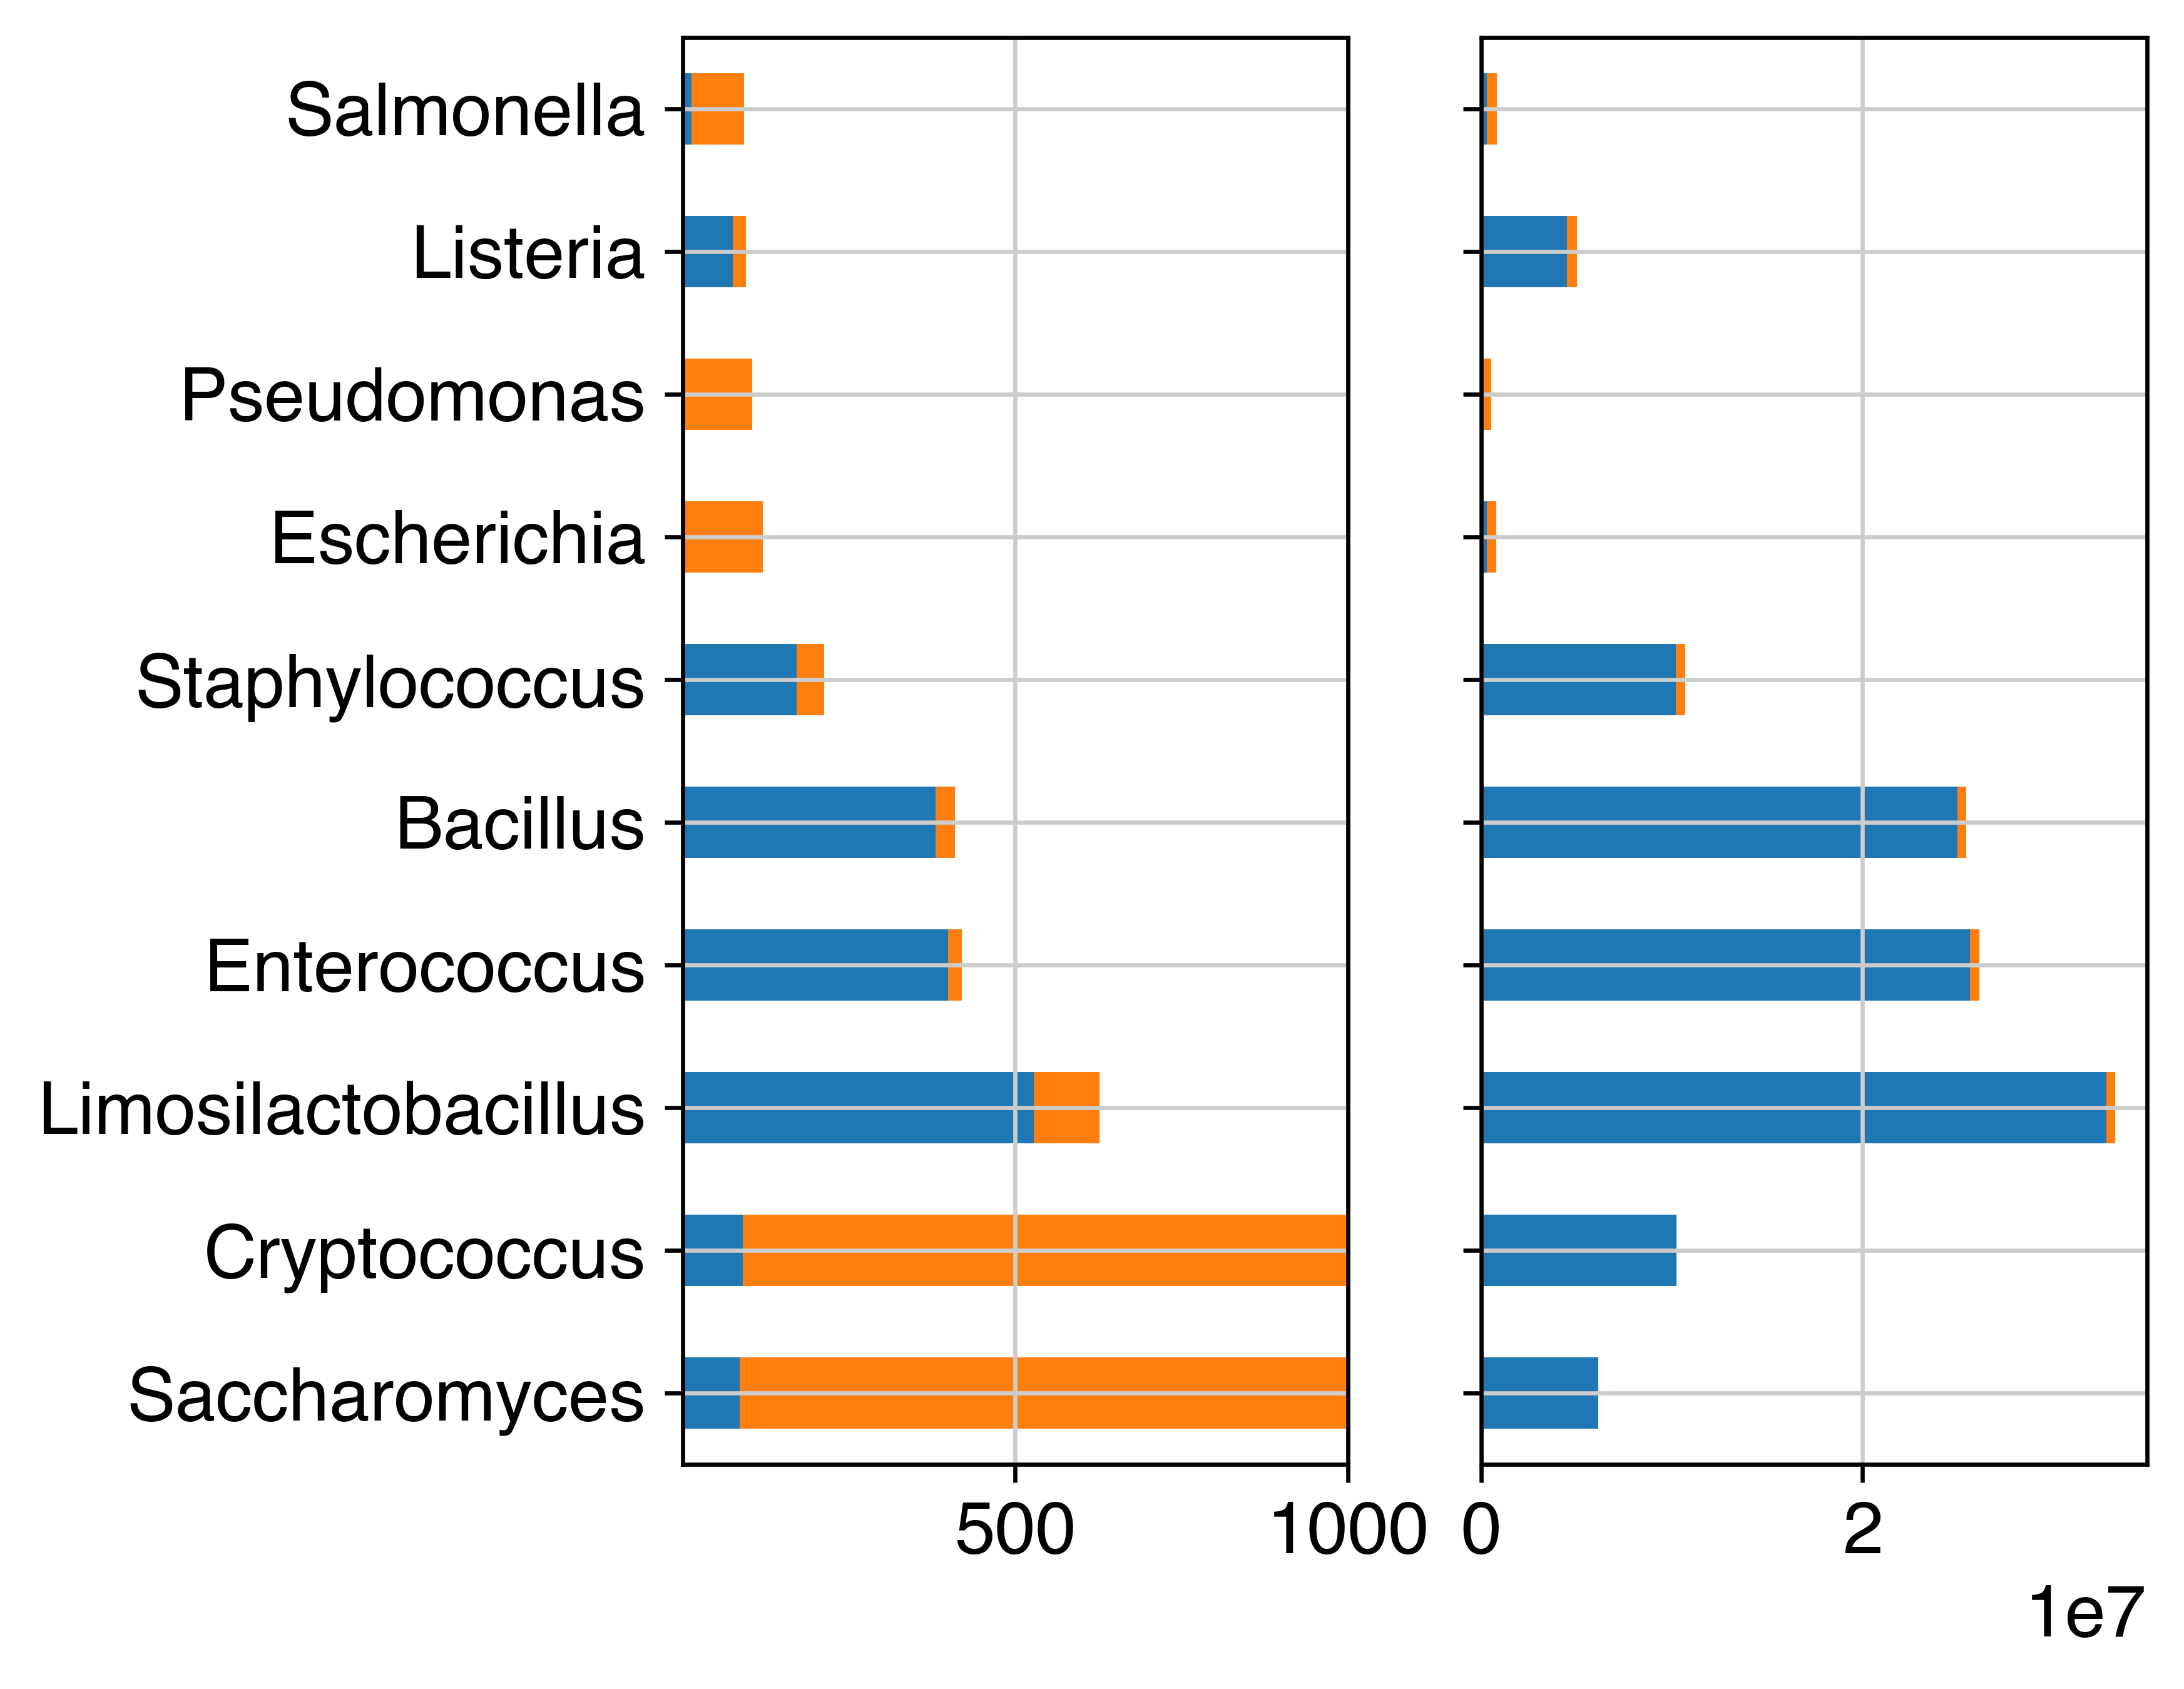

In [241]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True)
cluster_stat[['sc_bar_cnt', 'contig_bar_cnt']].plot(kind ='barh', 
                                                    stacked = ['sc_bar_cnt', 'contig_bar_cnt'],
                                                    ax=axes[0], 
                                                    legend=False,
                                                    #logx =  True,
                                                    xlim=(0.1, 1000)
                                                   )

cluster_stat[['sc_read_cnt','contig_read_cnt']].plot(kind ='barh',
                                                     stacked = ['sc_read_cnt','contig_read_cnt'],
                                                     ax=axes[1],
                                                     legend=False,
                                                     #logx=True,
                                                     #xlim=(1, 300000000)
                                                    )
fig.savefig(output_dir + 'zymo_cluster_stat_non_log.pdf', bbox_inches='tight')

In [242]:
# assemble the barcodes reads with extracted contigs reads 

sc_read_dir = '/drive1/xiangpeng/Project/bacteria/zymo_std/D6300_ZRC195925/splitted/single_cell/'
spade = '/drive1/xiangpeng/apps/SPAdes-3.15.3-Linux/bin/spades.py'
assemb_dir = '/drive1/xiangpeng/Project/bacteria/zymo_std/D6300_ZRC195925/splitted/assemb_sc_contig/'
contig_read_dir = '/drive1/xiangpeng/Project/bacteria/zymo_std/D6300_ZRC195925/splitted/contig_fq/'
cluster_ID_ls = ['Bacillus', 'Cryptococcus', 'Enterococcus', 
                 'Escherichia', 'Limosilactobacillus', 
                 'Listeria', 'Pseudomonas', 
                 'Saccharomyces', 'Salmonella', 
                 'Staphylococcus']

for c in cluster_ID_ls:
    c_dir = sc_read_dir + c +'/'
    sc_1 = c_dir + 'R1_combined.fastq'
    sc_2 = c_dir + 'R2_combined.fastq'
    
    contig_1 = contig_read_dir + c + '_combined_R1.fq'
    contig_2 = contig_read_dir + c + '_combined_R2.fq'
    
    assembed_out = assemb_dir+c+'/'
    mkdir_cmd = 'mkdir {}'.format(assembed_out)
    print(mkdir_cmd)
    #os.system(mkdir_cmd)
    
    assemb_cmd =  'python  {} -o {} --sc --pe-1 1 {} --pe-2 1 {} --pe-1 2 {} --pe-2 2 {} -t 32 '.format(spade,
                                                                                        assembed_out, 
                                                                                        sc_1, sc_2,
                                                                                        contig_1, contig_2)        
                                 
    print(assemb_cmd)
    os.system(assemb_cmd)

mkdir /drive1/xiangpeng/Project/bacteria/zymo_std/D6300_ZRC195925/splitted/assemb_sc_contig/Bacillus/
python  /drive1/xiangpeng/apps/SPAdes-3.15.3-Linux/bin/spades.py -o /drive1/xiangpeng/Project/bacteria/zymo_std/D6300_ZRC195925/splitted/assemb_sc_contig/Bacillus/ --sc --pe-1 1 /drive1/xiangpeng/Project/bacteria/zymo_std/D6300_ZRC195925/splitted/single_cell/Bacillus/R1_combined.fastq --pe-2 1 /drive1/xiangpeng/Project/bacteria/zymo_std/D6300_ZRC195925/splitted/single_cell/Bacillus/R2_combined.fastq --pe-1 2 /drive1/xiangpeng/Project/bacteria/zymo_std/D6300_ZRC195925/splitted/contig_fq/Bacillus_combined_R1.fq --pe-2 2 /drive1/xiangpeng/Project/bacteria/zymo_std/D6300_ZRC195925/splitted/contig_fq/Bacillus_combined_R2.fq -t 32 
mkdir /drive1/xiangpeng/Project/bacteria/zymo_std/D6300_ZRC195925/splitted/assemb_sc_contig/Cryptococcus/
python  /drive1/xiangpeng/apps/SPAdes-3.15.3-Linux/bin/spades.py -o /drive1/xiangpeng/Project/bacteria/zymo_std/D6300_ZRC195925/splitted/assemb_sc_contig/Cryp

In [243]:
# Quest analysis of the assembled results
ref_dir = '/drive1/xiangpeng/reference/zymo_std_6300/ZymoBIOMICS.STD.refseq.v2/Genomes/'
refs = {'Bacillus':'Bacillus_subtilis_complete_genome.fasta',
        'Cryptococcus':'Cryptococcus_neoformans_draft_genome.fasta',
        'Enterococcus':'Enterococcus_faecalis_complete_genome.fasta',
        'Escherichia':'Escherichia_coli_complete_genome.fasta',
        'Limosilactobacillus':'Lactobacillus_fermentum_complete_genome.fasta',
        'Listeria':'Listeria_monocytogenes_complete_genome.fasta',
        'Pseudomonas':'Pseudomonas_aeruginosa_complete_genome.fasta',
        'Saccharomyces':'Saccharomyces_cerevisiae_draft_genome.fasta',
        'Salmonella':'Salmonella_enterica_complete_genome.fasta',
        'Staphylococcus':'Staphylococcus_aureus_complete_genome.fasta'
       }




cluster_ID_ls = ['Bacillus', 'Cryptococcus', 'Enterococcus', 
                 'Escherichia', 'Limosilactobacillus', 
                 'Listeria', 'Pseudomonas', 
                 'Saccharomyces', 'Salmonella', 
                 'Staphylococcus']
quast_dir = '/drive1/xiangpeng/Project/bacteria/zymo_std/D6300_ZRC195925/splitted/assemb_sc_contig_quast/'
assemb_dir = '/drive1/xiangpeng/Project/bacteria/zymo_std/D6300_ZRC195925/splitted/assemb_sc_contig/'

for ref in refs.keys():
    genome = ref_dir + refs[ref]
    cell = ref
    contig = assemb_dir + cell +'/scaffolds.fasta'
    output_dir = quast_dir + cell + '/'
    #create folder for the quast output
    mkdir_cmd = 'mkdir ' + output_dir
    print(cell)
    os.system(mkdir_cmd)
    
    # quast analysis
    quast_cmd = 'python /home/xiangpeng/miniconda2/bin/quast -o {} -r {} -t 32 {}'.format(output_dir, genome, contig)
    print(quast_cmd)
    print('\n')
    os.system(quast_cmd)
    

Bacillus
python /home/xiangpeng/miniconda2/bin/quast -o /drive1/xiangpeng/Project/bacteria/zymo_std/D6300_ZRC195925/splitted/assemb_sc_contig_quast/Bacillus/ -r /drive1/xiangpeng/reference/zymo_std_6300/ZymoBIOMICS.STD.refseq.v2/Genomes/Bacillus_subtilis_complete_genome.fasta -t 32 /drive1/xiangpeng/Project/bacteria/zymo_std/D6300_ZRC195925/splitted/assemb_sc_contig/Bacillus/scaffolds.fasta


Cryptococcus
python /home/xiangpeng/miniconda2/bin/quast -o /drive1/xiangpeng/Project/bacteria/zymo_std/D6300_ZRC195925/splitted/assemb_sc_contig_quast/Cryptococcus/ -r /drive1/xiangpeng/reference/zymo_std_6300/ZymoBIOMICS.STD.refseq.v2/Genomes/Cryptococcus_neoformans_draft_genome.fasta -t 32 /drive1/xiangpeng/Project/bacteria/zymo_std/D6300_ZRC195925/splitted/assemb_sc_contig/Cryptococcus/scaffolds.fasta


Enterococcus
python /home/xiangpeng/miniconda2/bin/quast -o /drive1/xiangpeng/Project/bacteria/zymo_std/D6300_ZRC195925/splitted/assemb_sc_contig_quast/Enterococcus/ -r /drive1/xiangpeng/refere

In [244]:
# collect the result from the quast reports

quast_out_dir = '/drive1/xiangpeng/Project/bacteria/zymo_std/D6300_ZRC195925/splitted/assemb_sc_contig_quast/'
cluster_quast = pd.DataFrame()
for c in cluster_ID_ls:
    rep_dir = quast_out_dir+c+'/'
    rep = rep_dir + 'report.tsv'
    rep_df = pd.read_csv(rep, sep ='\t',index_col =0, )
    rep_df = rep_df.rename(columns = {'scaffolds':c})
    cluster_quast = pd.concat([cluster_quast,rep_df],axis=1)
cluster_quast = cluster_quast.T
cluster_quast.to_csv(quast_out_dir + 'quast_results.csv')

In [245]:
cluster_quast

Assembly,# contigs (>= 0 bp),# contigs (>= 1000 bp),# contigs (>= 5000 bp),# contigs (>= 10000 bp),# contigs (>= 25000 bp),# contigs (>= 50000 bp),Total length (>= 0 bp),Total length (>= 1000 bp),Total length (>= 5000 bp),Total length (>= 10000 bp),...,Largest alignment,Total aligned length,NA50,NGA50,NGA75,LA50,LGA50,LGA75,NA75,LA75
Bacillus,10099,702,138,111,66,23,8198285,5304594,4339921,4151976,...,130907,3981008,26535,49224,26792,57,26,55,NaN,NaN
Cryptococcus,5276,157,8,1,0,0,1763381,317768,58831,14169,...,4081,155490,NaN,-,NaN,NaN,NaN,NaN,NaN,NaN
Enterococcus,11601,705,207,116,24,1,6792654,3868010,2889882,2255332,...,58547,2816231,7063,16916,8908,137,58,115,NaN,NaN
Escherichia,365,135,103,83,49,35,4713151,4663455,4588780,4437345,...,253116,4680449,72732,70504,35882,20,22,44,38442,41
Limosilactobacillus,14652,559,135,75,16,1,6585424,2657725,1859004,1422416,...,42502,1801599,NaN,12733,6133,NaN,49,103,NaN,NaN
Listeria,1469,64,39,33,26,19,3308581,2973605,2926551,2889324,...,237492,2919548,142071,142071,76973,8,8,15,69351,16
Pseudomonas,254,101,79,71,59,47,6721410,6691950,6641938,6589159,...,319061,6696233,135105,122483,68529,16,17,35,71530,34
Saccharomyces,6090,240,7,2,0,0,1898492,400372,60809,25547,...,11378,709773,723,-,NaN,398,NaN,NaN,443,784
Salmonella,626,110,79,66,42,30,4751300,4691877,4617112,4521170,...,234519,4307394,45553,45016,20166,27,28,68,20619,64
Staphylococcus,7729,230,65,52,37,18,4481355,2975629,2667348,2575044,...,171410,2676341,47560,54666,32388,19,14,30,19413,43


<AxesSubplot:>

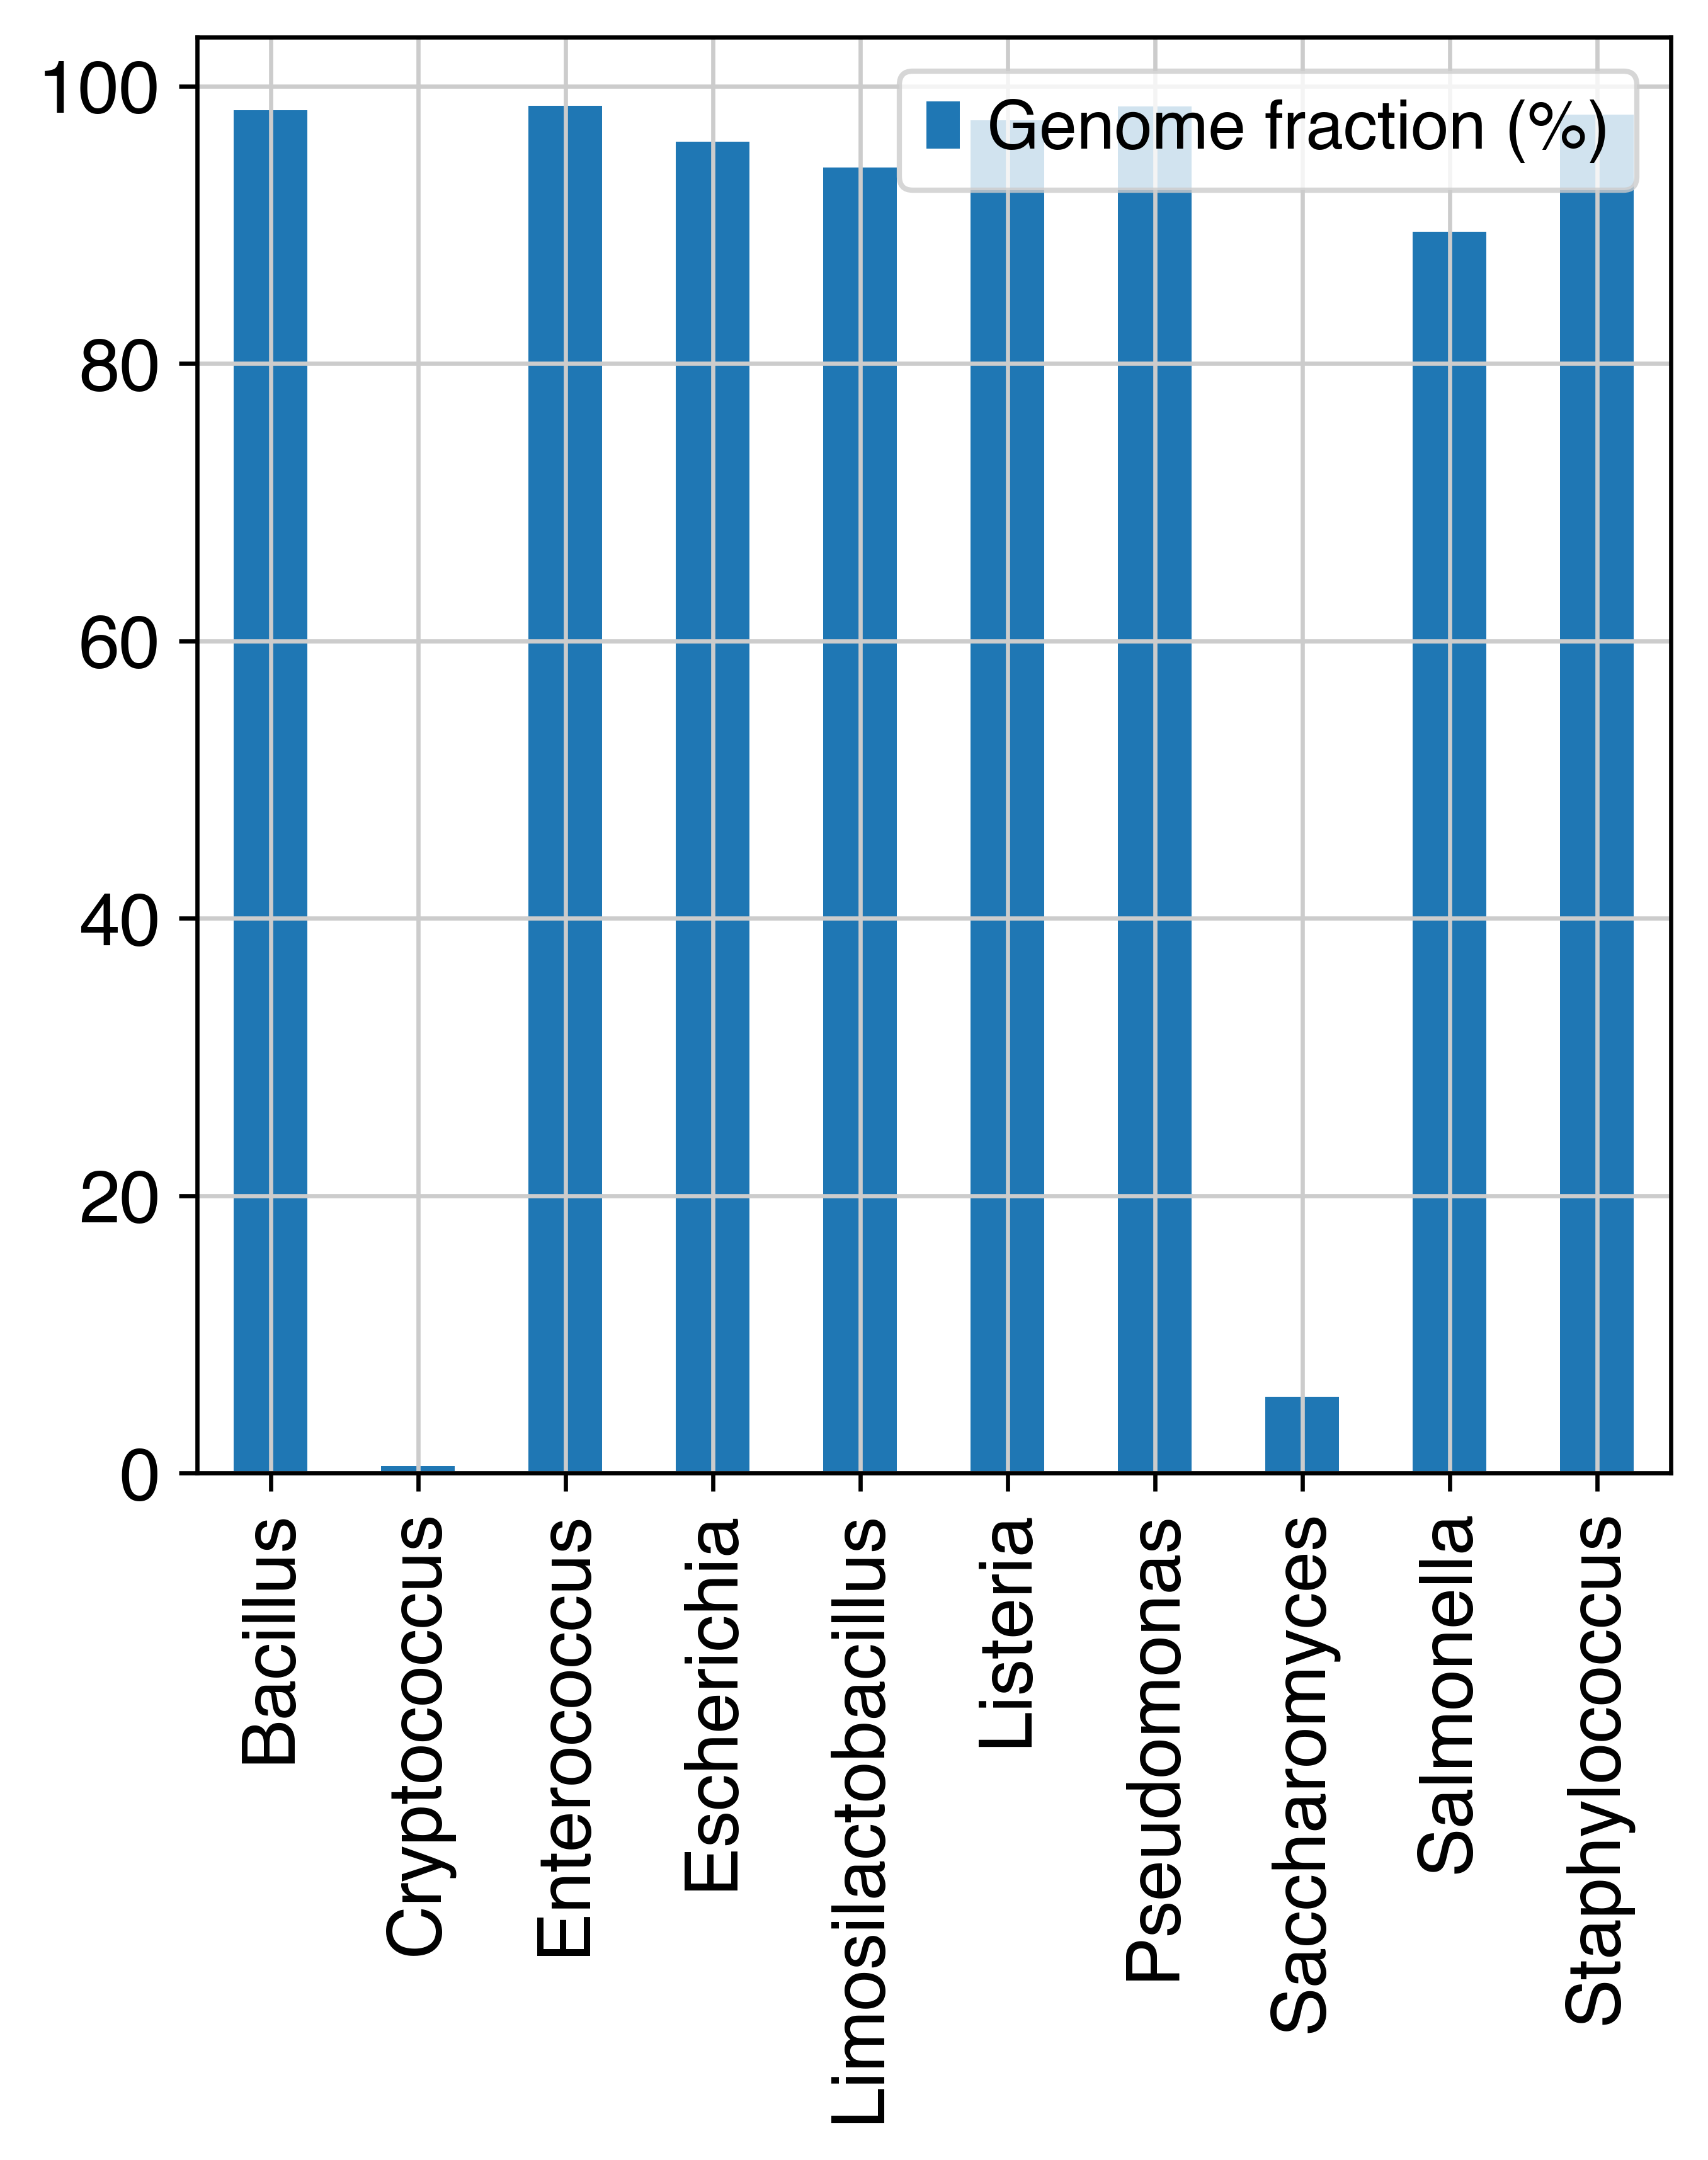

In [247]:
col = cluster_quast.columns.tolist()
cluster_quast[col]=cluster_quast[col].apply(pd.to_numeric, errors ='coerce')
cluster_quast

cluster_quast.plot.bar(y='Genome fraction (%)')

In [248]:
cluster_quast['normalized_total_length'] = cluster_quast['Total length']/cluster_quast['Reference length']
cluster_stat['Genome_fraction']=cluster_quast['Genome fraction (%)'].astype('float')
cluster_stat['Relative_length']=cluster_quast['normalized_total_length']

In [249]:
cluster_stat

,sc_bar_cnt,contig_bar_cnt,sc_read_cnt,contig_read_cnt,Genome_fraction,Relative_length
Saccharomyces,86,3227,6125734,10642,5.523,0.072699
Cryptococcus,91,1094,10236022,5406,0.532,0.020867
Limosilactobacillus,528,99,32786056,467787,94.155,1.937669
Enterococcus,399,21,25624191,498788,98.586,1.622450
Bacillus,380,29,24968672,486883,98.283,1.522593
Staphylococcus,172,41,10215012,475105,97.967,1.181657
Escherichia,4,117,311550,491615,95.979,0.960724
Pseudomonas,1,104,34021,509074,98.540,0.986729
Listeria,76,19,4499306,534781,97.533,1.007971
Salmonella,14,79,287863,522096,89.517,0.978131


In [250]:
cluster_stat.to_csv(output_dir + 'zymo_cluster_stat.csv')